In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import joblib, json, sys, os
from IPython.display import Image, display_png

sys.path.append("../script/")
from MergeBrain import WholeBrainCells
import matplotlib.pyplot as plt
import pandas as pd

import sys, os, os.path, re, csv, math
import linecache
import numpy as  np
import pandas as pd
from matplotlib import pyplot as plt
from statistics import mean,stdev
import seaborn as sns

import csv
import pprint
import ants
import tifffile
from multiprocessing import Pool
import datetime
from itertools import product

import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json

import datetime

import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
plt.rcParams['font.size'] = 20

In [2]:
data_Atlas = pd.read_csv(filepath_or_buffer="/export3/Imaging/atlas_for_fig/count_all_rgb.csv", encoding="ms932", sep=",")
# インプットの項目数（行数 * カラム数）を返却します。
data_atlas=np.array(data_Atlas.values.tolist())
#print(data_Atlas.size)
# 指定したカラムだけ抽出したDataFrameオブジェクトを返却します。
data_GO = pd.read_csv(filepath_or_buffer="/export3/Imaging/atlas_for_fig/GOvsID_6region_removed.csv", encoding="ms932", sep=",")
# 指定したカラムだけ抽出したDataFrameオブジェクトを返却します。
data_GO

,id,graph_order,R,G,B
0,997,0,255,255,255
1,68,7,38,143,69
2,667,8,38,143,69
3,52192,9,38,143,69
4,52196,10,38,143,69
...,...,...,...,...,...
666,129,1299,170,170,170
667,140,1300,170,170,170
668,145,1301,170,170,170
669,153,1302,170,170,170


In [3]:
# 下記は一部のidだけが対象
dir= "/export3/Imaging/cubic-atlas_v1-1/cubic-atlas/"
dir_ana=dir+"summary_CUBIC-Atlas-1-1.csv"


data_id = pd.read_csv(filepath_or_buffer=dir_ana, encoding="ms932", sep=",")
data_id

,id,acronym,node_name,graph_order,rgb_triplet,cell_count,volume(mm3),density(cells/mm3)
0,997,root,root,0,"[255, 255, 255]",78620375,506.05289,155359.99590
1,8,grey,Basic cell groups and regions,1,"[191, 218, 227]",70525778,449.60086,156863.08540
2,567,CH,Cerebrum,2,"[176, 240, 255]",39291452,275.87673,142423.94190
3,688,CTX,Cerebral cortex,3,"[176, 255, 184]",31750427,221.54964,143310.66800
4,695,CTXpl,Cortical plate,4,"[112, 255, 112]",30687805,212.64380,144315.54300
...,...,...,...,...,...,...,...,...
834,129,V3,third ventricle,1299,"[170, 170, 170]",144614,0.90005,160673.85380
835,140,AQ,cerebral aqueduct,1300,"[170, 170, 170]",26972,0.40620,66400.27696
836,145,V4,fourth ventricle,1301,"[170, 170, 170]",118275,0.96495,122570.72070
837,153,V4r,lateral recess,1302,"[170, 170, 170]",71934,0.46333,155254.98260


In [4]:
conditions = {
    "WT_1m": ["#4_APPmodel_Ctr1m_1_2022_1104_1550","#4_APPmodel_Ctr1m_2_2022_1108_959","#4_APPmodel_Ctr1m_3_2022_1209_1751"],
    "WT_2m": ["8w_B6JWT_atlas_1_2022_0924_1847","8w_B6JWT_atlas_2_2022_0926_1326", "8w_B6JWT_atlas_3_2022_1005_1110", "8w_B6JWT_atlas_4_2022_1010_2030","8w_B6JWT_atlas_5_2023_0423_1604",],
    "WT_3m": ["#5_APPmodel_Ctr3m_1_2023_0113_1230", "#5_APPmodel_Ctr3m_2_2023_0210_1142", "#5_APPmodel_Ctr3m_3_2023_0227_1605", "#4_APPmodel_Ctr3m_4_2023_0427_1444",],
    "WT_5m": ["#4_APPmodel_Ctr5m_1_2022_1026_252", "#4_APPmodel_Ctr5m_2_2022_1028_2336", "#4_APPmodel_Ctr5m_3_2022_1101_140", "#4_APPmodel_Ctr5m_4_2023_0512_2057"],
    "WT_7m": [ "#5_APPmodel_Ctr7m_1_2023_0206_1534","#5_APPmodel_Ctr7m_2_2023_0313_1111","#5_APPmodel_Ctr7m_3_2023_0331_2139","#4_APPmodel_Ctr7m_4_2023_0516_1559","#5_APPmodel_Ctr7m_5_2023_0522_2218"],
    "WT_9m": [ "#5_APPmodel_Ctr9m_1_2023_0130_1607", "#5_APPmodel_Ctr9m_2_2023_0216_2052" ,"#5_APPmodel_Ctr9m_3_2023_0322_2014","#5_APPmodel_Ctr9m_4_2023_0518_1449"],
    "WT_12m": ["56w_B6JWT_atlas_1_2022_1128_1548", "56w_B6JWT_atlas_2_2022_1221_1537", "56w_B6JWT_atlas_3_2022_1224_1718"],
    
    "APP_1m": ["#4_APPmodel_APP1m_1_2022_1102_1304", "#4_APPmodel_APP1m_2_2022_1106_1708","#4_APPmodel_APP1m_3_2022_1213_2151","#4_APPmodel_APP1m_4_2023_0417_2052", ],
    "APP_3m": [ "#5_APPmodel_APP3m_2_2023_0123_1645", "#5_APPmodel_APP3m_3_2023_0212_2217","#5_APPmodel_APP3m_4_2023_0214_2027","#4_APPmodel_APP3m_5_2023_0502_1423",],
   "APP_5m": ["#4_APPmodel_APP5m_1_2022_1024_1336", "#4_APPmodel_APP5m_2_2022_1027_1333","#4_APPmodel_APP5m_3_2022_1030_1257", "#4_APPmodel_APP5m_4_2023_0509_1021"],
    "APP_7m": ["#5_APPmodel_APP7m_2_2023_0315_1540","#5_APPmodel_APP7m_3_2023_0310_1401","#5_APPmodel_APP7m_4_2023_0317_1630", "#5_APPmodel_APP7m_5_2023_0520_1723"],
    "APP_9m": ["#5_APPmodel_APP9m_1_2023_0117_1352","#5_APPmodel_APP9m_2_2023_0327_1425", "#5_APPmodel_APP9m_3_2023_0329_1611", "#5_APPmodel_APP9m_4_2023_0403_1443" ],
       
    "VCP_mut_2m": ["VCPmodel_E524A_0.5x_1_2022_0624_1303", "VCPmodel_E524A_0.5x_2_2022_0626_1338", "VCPmodel_E524A_0.5x_4_2022_0922_1217", "VCPmodel_E524A_0.5x_6_2022_0628_1157"], 
   "VCP_WT_2m": ["VCPmodel_WT_0.5x_1_2022_0625_1104","VCPmodel_WT_0.5x_2_2022_0917_1808", "VCPmodel_WT_0.5x_3_2022_0627_1257", "VCPmodel_WT_0.5x_4_2022_0921_950","VCPmodel_WT_0.5x_5_2022_0923_1454","VCPmodel_WT_0.5x_6_2022_0929_953"],
    "newVCP_mut_2m": ["#5_VCPmodel_E524A_0.5x_1_2023_0120_1929","#5_VCPmodel_E524A_0.5x_2_2023_0407_1031", "#5_VCPmodel_E524A_0.5x_3_2023_0413_2036"], 
   "newVCP_WT_2m": ["#5_VCPmodel_WT_0.5x_1_2023_0405_1108","#5_VCPmodel_WT_0.5x_2_2023_0115_1852","#5_VCPmodel_WT_0.5x_3_2023_0410_1246"], 
    
    "TMT_2m": ["#3_TMTmodel_TMT3.0_8w_1_2022_1014_1410", "#3_TMTmodel_TMT3.0_8w_2_2022_1020_938", "#3_TMTmodel_TMT3.0_8w_3_2022_1023_501", "#3_TMTmodel_TMT_8w_5_2022_1205_1147",],
  "Saline_2m": ["#3_TMTmodel_Saline_8w_1_2022_1016_1318", "#3_TMTmodel_Saline_8w_2_2022_1018_2103","#3_TMTmodel_Saline_8w_3_2022_1021_1910", "#3_TMTmodel_Saline_8w_4_2022_1202_1349", "#3_TMTmodel_Saline_8w_5_2022_1217_1723", "#3_TMTmodel_Saline_8w_6_2022_1216_001"],
    
}

In [5]:
atlas_id = 52196

Samples = ['Neuronomics/#4_APPmodel_Ctr1m_3_2022_1209_1751',
 'Neuronomics/#4_APPmodel_Ctr5m_3_2022_1101_140',
 'Neuronomics/#4_APPmodel_Ctr5m_2_2022_1028_2336',
 'Neuronomics/#4_APPmodel_Ctr7m_4_2023_0516_1559',
 'Neuronomics/#5_APPmodel_Ctr9m_1_2023_0130_1607']

Neuronomics/#4_APPmodel_Ctr1m_3_2022_1209_1751
Neuronomics/#4_APPmodel_Ctr5m_3_2022_1101_140
Neuronomics/#4_APPmodel_Ctr5m_2_2022_1028_2336
Neuronomics/#4_APPmodel_Ctr7m_4_2023_0516_1559
Neuronomics/#5_APPmodel_Ctr9m_1_2023_0130_1607


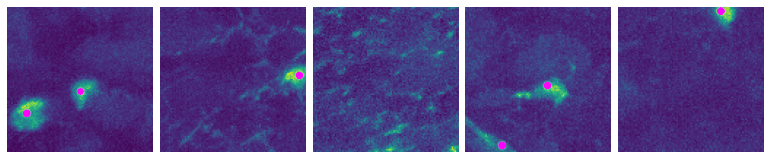

In [19]:


atlas_id = 52196

import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# カスタムカラーマップの作成
def create_colormap(base_color):
    colors = [(1, 1, 1, 0), base_color + (1,)]  # start with white (fully transparent), end with base_color
    return LinearSegmentedColormap.from_list(f"{base_color}", colors)

# カラーマップの定義
magenta_cmap = create_colormap((1, 0, 1))
green_cmap = create_colormap((0, 1, 0))
cyan_cmap = create_colormap((0, 1, 1))
gray_cmap = plt.cm.viridis  # グレースケールカラーマップ
dark_magenta_cmap = create_colormap((0.5, 0, 0.5))
dark_green_cmap = create_colormap((0, 0.5, 0))
dark_cyan_cmap = create_colormap((0, 0.5, 0.5))


#closest_sample = closest_sample1  # 0番目を選択した。
#Samples = ["Neuronomics/" + info['sample_name'] for info in closest_sample['closest_samples'].values()]

# プロットの初期化（5つのサブプロット）
fig, axes = plt.subplots(nrows=1, ncols=len(Samples), figsize=(15, 3))  # 各画像の横幅を調整

for i, Sample in enumerate(Samples):
    print(Sample)
    
    base_path = f"/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.4/{Sample.replace('Neuronomics/','')}"
    paths = {
        'neun': f"{base_path}_ROI_Iba1_{atlas_id}.tif",
        'neun_points': f"{base_path}_ROI_Iba1_points_{atlas_id}.tif"
    }

    # 画像の読み込み
    images = {name: tifffile.imread(path)[5:35, 100:200, 20+0:20+100]  for name, path in paths.items()}
    
    # Z方向のマックスプロジェクション
    max_projects = {name: np.max(img, axis=0) for name, img in images.items()}
    
    # 画像の正規化
    vmins = {name: np.percentile(img, 0) for name, img in max_projects.items()}
    vmaxs = {name: np.percentile(img, 100) for name, img in max_projects.items()}
    
    # 軸に画像を描画
    ax = axes[i]
    ax.imshow(max_projects['neun'], cmap=gray_cmap, vmin=vmins['neun'], vmax=vmaxs['neun'])
    ax.imshow(max_projects['neun_points'], cmap=magenta_cmap, vmin=0, vmax=0.005)  # ポイント画像の描画
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

# PDFとして図を保存
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.4/FRP6a_APP.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [6]:
atlas_id = 52196

Samples = ['Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304',
 'Neuronomics/#5_APPmodel_APP3m_4_2023_0214_2027',
 'Neuronomics/#4_APPmodel_APP5m_4_2023_0509_1021',
 'Neuronomics/#5_APPmodel_APP7m_5_2023_0520_1723',
 'Neuronomics/#5_APPmodel_APP9m_4_2023_0403_1443']

Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
Neuronomics/#5_APPmodel_APP3m_4_2023_0214_2027
Neuronomics/#4_APPmodel_APP5m_4_2023_0509_1021
Neuronomics/#5_APPmodel_APP7m_5_2023_0520_1723
Neuronomics/#5_APPmodel_APP9m_4_2023_0403_1443


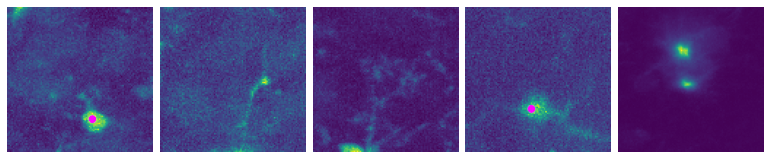

In [9]:


atlas_id = 52196

import tifffile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# カスタムカラーマップの作成
def create_colormap(base_color):
    colors = [(1, 1, 1, 0), base_color + (1,)]  # start with white (fully transparent), end with base_color
    return LinearSegmentedColormap.from_list(f"{base_color}", colors)

# カラーマップの定義
magenta_cmap = create_colormap((1, 0, 1))
green_cmap = create_colormap((0, 1, 0))
cyan_cmap = create_colormap((0, 1, 1))
gray_cmap = plt.cm.viridis  # グレースケールカラーマップ
dark_magenta_cmap = create_colormap((0.5, 0, 0.5))
dark_green_cmap = create_colormap((0, 0.5, 0))
dark_cyan_cmap = create_colormap((0, 0.5, 0.5))


#closest_sample = closest_sample1  # 0番目を選択した。
#Samples = ["Neuronomics/" + info['sample_name'] for info in closest_sample['closest_samples'].values()]

# プロットの初期化（5つのサブプロット）
fig, axes = plt.subplots(nrows=1, ncols=len(Samples), figsize=(15, 3))  # 各画像の横幅を調整

for i, Sample in enumerate(Samples):
    print(Sample)
    
    base_path = f"/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.4/{Sample.replace('Neuronomics/','')}"
    paths = {
        'neun': f"{base_path}_ROI_Iba1_{atlas_id}.tif",
        'neun_points': f"{base_path}_ROI_Iba1_points_{atlas_id}.tif"
    }

    # 画像の読み込み
    images = {name: tifffile.imread(path)[5:35, 100:200, 20+0:20+100]  for name, path in paths.items()}
    
    # Z方向のマックスプロジェクション
    max_projects = {name: np.max(img, axis=0) for name, img in images.items()}
    
    # 画像の正規化
    vmins = {name: np.percentile(img, 0) for name, img in max_projects.items()}
    vmaxs = {name: np.percentile(img, 100) for name, img in max_projects.items()}
    
    # 軸に画像を描画
    ax = axes[i]
    ax.imshow(max_projects['neun'], cmap=gray_cmap, vmin=vmins['neun'], vmax=vmaxs['neun'])
    ax.imshow(max_projects['neun_points'], cmap=magenta_cmap, vmin=0, vmax=0.005)  # ポイント画像の描画
    ax.set_aspect('equal')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

# PDFとして図を保存
#plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.4/FRP6a_APP.pdf',
#            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()


In [36]:
Sample 

'Neuronomics/#4_APPmodel_Ctr1m_3_2022_1209_1751'

In [ ]:
# まずは、APP 1m, 9m  の n = 1の 比較をする 
# ミクログリアは各sample ごとに、n=3ずつとるということで。

In [12]:
# まずは、対象となる画像を保存する。
atlas_id 

52192

In [6]:
# 現状、FRP5, MGm, SNr, CA1, MOB, CENT2 を考える方針で。
atlas_id  = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]
print(atlas_id)
manual_landmark = np.array([468, 244, 275])*10 # manual でも決めれる # SCA上の座標
manual_landmark

52192


array([4680, 2440, 2750])

In [7]:
import numpy as np
import os
import tifffile
import json
from scipy.spatial import cKDTree

# 定数定義
ROI_xy_pix = 100
ROI_z_pix = 80
dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

    
dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

import numpy as np
import os
import tifffile
import json
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import concurrent.futures
import datetime


dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

    
dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])


def process_file_all(fw_dir_nu_, file_name, category):
    try:
        fw_dir_intensities_ = fw_dir_nu_.replace("nu_R_/result", "intensities_")
        tmp_points_intensities_ = np.fromfile(os.path.join(fw_dir_intensities_, file_name), dtype=dt_annotated_classified_intensity)

        fw_dir_nu_R_ = fw_dir_nu_ #.replace("intensities_","nu_R_/result")
        tmp_points_nu_R_ = np.fromfile(os.path.join(fw_dir_nu_R_, file_name), dtype=dt_annotated_init)

        mask = (tmp_points_nu_R_["stitched_x"] != 0.0) & (tmp_points_nu_R_["stitched_y"] != 0.0) & (tmp_points_nu_R_["is_positive"] > 0.0)
        tmp_points_nu_R_2 = tmp_points_nu_R_[mask]

        fw_dir_nu_candidate_nu_ = fw_dir_nu_.replace("nu_R_/result","candidate_nu_")
        tmp_points_candidate_nu_ = np.fromfile(os.path.join(fw_dir_nu_candidate_nu_, file_name), dtype=dt_local)
        tmp_points_candidate_nu_2 = tmp_points_candidate_nu_[mask]

        tmp_points_intensities_["local_x"] = tmp_points_candidate_nu_2["local_x"]
        tmp_points_intensities_["local_y"] = tmp_points_candidate_nu_2["local_y"]
        tmp_points_intensities_["local_z"] = tmp_points_candidate_nu_2["local_z"]
        tmp_points_intensities_["mapped_x"] = tmp_points_nu_R_2["mapped_x"]
        tmp_points_intensities_["mapped_y"] = tmp_points_nu_R_2["mapped_y"]
        tmp_points_intensities_["mapped_z"] = tmp_points_nu_R_2["mapped_z"]
        tmp_points_intensities_["atlas_id"] = tmp_points_nu_R_2["atlas_id"]
        tmp_points_intensities_["intensity"] = tmp_points_candidate_nu_2["intensity"]
        tmp_points_intensities_["structureness"] = tmp_points_candidate_nu_2["structureness"]

        # Add new metadata columns for file_name and category
        file_name_column = np.full(tmp_points_intensities_.shape, file_name, dtype=object)
        category_column = np.full(tmp_points_intensities_.shape, category, dtype=object)

        # Add file_name and category to the returned structured array
        return tmp_points_intensities_, file_name_column, category_column

    except Exception as e:
        #print(f"Error processing {file_name}: {e}")
        return np.empty((0, len(dt_annotated_classified_intensity.names))), [], []

# Process FW and RV files with category labels
def process_files(fw_dir_nu, file_list, category):
    with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(process_file_all, [fw_dir_nu] * len(file_list), file_list, [category] * len(file_list)))

    # Separate the points, file names, and categories from the results
    points_list = [result[0] for result in results if result[0].size > 0]
    file_names_list = [result[1] for result in results if len(result[1]) > 0]
    categories_list = [result[2] for result in results if len(result[2]) > 0]

    # Flatten the lists and concatenate arrays
    if points_list:
        points_array = np.concatenate(points_list)
        file_names_array = np.concatenate(file_names_list)
        categories_array = np.concatenate(categories_list)
        return points_array, file_names_array, categories_array
    else:
        return np.empty((0,)), np.array([]), np.array([])

    
Sample = "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304"
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"].replace("intensities_", "nu_R_/result")
# Read FW and RV files
print("FW reading")
fw_dir_nu_ = fw_dir_nu + "/FW/"
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()
points_fw, file_names_fw, categories_fw = process_files(fw_dir_nu_, file_list_fw, "FW")

print("RV reading")
fw_dir_nu_ = fw_dir_nu + "/RV/"
file_list_rv = os.listdir(fw_dir_nu_)
file_list_rv.sort()
points_rv, file_names_rv, categories_rv = process_files(fw_dir_nu_, file_list_rv, "RV")
# Combine FW and RV results
points_all = np.concatenate([points_fw, points_rv])
file_names_all = np.concatenate([file_names_fw, file_names_rv])
categories_all = np.concatenate([categories_fw, categories_rv])


def load_image(filepath, dtype=np.uint16, height=2048, width=2060, flip_y=False, trim_width=True):
    """画像ファイルをロードし、必要な変換を適用する関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    if trim_width:
        img = img[:, :2048]  # 幅を2048にトリミング
    if flip_y:
        img = np.flip(img, 0)  # Y軸を反転
    return img

    
def extract_roi(center_x, center_y, center_z, fw_dir, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0), flip_y=False):
    """指定された座標を中心とした3D ROIを抽出する関数"""
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    z_offset = num_z_slices // 2
    px, py = int(corrected_x), int(corrected_y)
    half_roi_px = roi_pixel_size // 2

    roi_3d = []
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir, f"{200000 + file_index}.bin")
        if os.path.exists(filepath):
            img = load_image(filepath, flip_y=flip_y)
            roi = img[py - half_roi_px:py + half_roi_px, px - half_roi_px:px + half_roi_px]
            roi_3d.append(roi)
    return np.array(roi_3d)

# ROI画像保存用関数
def save_roi_image(roi_images, filename):
    """ROI画像を保存する関数"""
    tifffile.imsave(filename, roi_images.astype(np.float32))
    print(f"Saved ROI to {filename}")

def save_density_image(points_all, center_x, center_y, center_z, filename):
    """3D密度画像を生成して保存する関数"""
    z_offset = ROI_z_pix // 2
    xy_offset = ROI_xy_pix // 2

    filtered = (points_all['local_z'] >= center_z - z_offset) & (points_all['local_z'] < center_z + z_offset) & \
               (points_all['local_x'] >= center_x - xy_offset) & (points_all['local_x'] < center_x + xy_offset) & \
               (points_all['local_y'] >= center_y - xy_offset) & (points_all['local_y'] < center_y + xy_offset)

    matching_points = points_all[filtered]
    depth, height, width = ROI_z_pix, ROI_xy_pix, ROI_xy_pix

    img_density, _ = np.histogramdd(
        np.vstack([
            matching_points['local_z'] - (center_z - z_offset),
            matching_points['local_y'] - (center_y - xy_offset),
            matching_points['local_x'] - (center_x - xy_offset)
        ]).T,
        bins=(depth, height, width),
        range=[(0, depth), (0, height), (0, width)]
    )

    tifffile.imsave(filename, gaussian_filter(img_density, sigma=1.0).astype(np.float32))
    print(f"Saved density image to {filename}")

sample = Sample #"Neuronomics/#3_TMTmodel_Saline_8w_1_2022_1016_1318"
param_path = f"/home/mitani/CUBIC-informatics/param/{sample}/param_multichannel-rank.json"

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"]


# SCAとatlas_idの条件を満たすsrcデータをフィルタリング
src = np.fromfile(f"{fw_dir_nu}/SCA_registered_cell_coordinates_ver2_2.bin", dtype=dt_annotation2)
filtered_src = src[(src['atlas_id'] == atlas_id) & (src['SCA_x'] < 264 * 50)]


# 重心位置を計算
stitched_center = np.array([
    filtered_src['SCA_x'].mean(),
    filtered_src['SCA_y'].mean(),
    filtered_src['SCA_z'].mean()
])

NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
NeuN_cluster_noise_threshold_list = [0.55] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず

Classified_cells = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
         "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
         "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin", dtype = dt_simple2 )
print(len(Classified_cells))

stitched_center = manual_landmark # manual でも決めれる

# 最近傍点を検索
stitched_points = np.column_stack((src['SCA_x'], src['SCA_y'], src['SCA_z']))
tree = cKDTree(stitched_points)
_, index = tree.query(stitched_center)

print(src[index])

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"].replace("intensities_", "nu_R_/result")
print("FW reading")
fw_dir_nu_ = fw_dir_nu + "/FW/"


# 最近傍点のsrcとpoints_allを参照
matching_point = points_all [index]
print(matching_point)

file_names_all_most_frequent_element = file_names_all[index]
categories_all_most_frequent_element = categories_all[index]
print(file_names_all_most_frequent_element, categories_all_most_frequent_element)

print("###########  Nuclear ROI image save ####################")

# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex488_em620_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。"""
    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2 

    # X, Y座標をピクセル単位に変換
    px = int(center_x)
    py = int(center_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset ):
        file_index = int(center_z) + i  # center_zを基準にして周囲のスライスを取得
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")  # ファイルパスを生成
        #print(filepath)
        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, ROI_xy_pix, ROI_z_pix)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Nuclear_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )


print("###########  NeuN ROI image save ####################")
# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex642_em720_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    img = np.flip(img, 0)  # Y軸を反転
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0)):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。色収差の補正を考慮。"""
    # 中心座標を色収差のオフセットで補正
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2

    # X, Y座標をピクセル単位に変換
    px = int(corrected_x)
    py = int(corrected_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")

        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

if  categories_all_most_frequent_element == "FW":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_NeuN"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_NeuN"] 

if  categories_all_most_frequent_element == "RV":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_NeuN"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_NeuN"]    

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, offset=offset_left_NeuN)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_NeuN_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )

print("###########  Iba1 ROI image save ####################")
# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex592_em620_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    #img = np.flip(img, 0)  # Y軸を反転
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0)):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。色収差の補正を考慮。"""
    # 中心座標を色収差のオフセットで補正
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2

    # X, Y座標をピクセル単位に変換
    px = int(corrected_x)
    py = int(corrected_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")

        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

if  categories_all_most_frequent_element == "FW":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_Iba1"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_Iba1"] 

if  categories_all_most_frequent_element == "RV":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_Iba1"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_Iba1"]    

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, offset=offset_left_NeuN)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Iba1_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )    


print("###########  Nuclear ROI points save ####################")
from scipy.spatial import cKDTree
import numpy as np
import datetime

dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])

param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"]
import numpy as np
import os
import tifffile

# 以下の範囲はROI抽出時と完全に一致させる
px = int(center_x)  # X座標のピクセル中心
py = int(center_y)  # Y座標のピクセル中心
z_offset = ROI_z_pix // 2  # Z方向のオフセット（50スライス上下）
xy_offset = ROI_xy_pix // 2 

filtered = np.array(
    #(points_all['local_z'] >= center_z - z_offset) & (points_all['local_z'] < center_z + z_offset) &
    #(points_all['local_x'] >= center_x - xy_offset) & (points_all['local_x'] < center_x + xy_offset) &
    #(points_all['local_y'] >= center_y - xy_offset) & (points_all['local_y'] < center_y + xy_offset) &
    (src['atlas_id'] == atlas_id) & #(Classified_cells["NeuN_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
    #(src['stitched_z'] >= matching_point["stitched_z"] - z_offset*2.5*2) & (src['stitched_z'] < matching_point["stitched_z"]+ z_offset*2.5*2)&
    #(src['stitched_y'] >= matching_point["stitched_y"] - xy_offset*0.65*2) & (src['stitched_y'] < matching_point["stitched_y"] + xy_offset*0.65*2)&
    #(src['stitched_x'] >= matching_point["stitched_x"] - xy_offset*0.65*2) & (src['stitched_x'] < matching_point["stitched_x"] + xy_offset*0.65*2)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048 # ROIと同じサイズ

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'] ,#- ( - xy_offset),
        matching_elements['local_x'], #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Nuclear_points_"+str(atlas_id)+".tif"
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'] ,#- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_Nuclear_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)

print("###########  NeuN ROI points save ####################")

filtered = np.array(
    (src['atlas_id'] == atlas_id) & (Classified_cells["NeuN_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048 #ROI_xy_pix # ROIと同じサイズ

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'], #- ( - xy_offset),
        matching_elements['local_x'] #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") +  "_ROI_NeuN_points_"+str(atlas_id)+".tif"
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'], #- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_NeuN_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)

print("###########  Iba1 ROI points save ####################")

filtered = np.array(
    (src['atlas_id'] == atlas_id) & (Classified_cells["Iba1_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'], #- ( - xy_offset),
        matching_elements['local_x'] #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") +  "_ROI_Iba1_points_"+str(atlas_id)+".tif" 
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'], #- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_Iba1_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)


/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304/param_multichannel-rank.json
FW reading
RV reading
98780344
(9356.85, 7706.101, 5467.9233, 6854.6274, 5664.2446, 5490.212, 4684.1353, 2447.0706, 2741.5918, 52192)
FW reading
(751.91547, 1800.9237, 1003.4165, 9356.85, 7706.101, 5467.9233, 6854.6274, 5664.2446, 5490.212, 52192, 1., 0.33600086, 9200.976, 0.3430653, 0.3755009, 0.07446332, 0.14766625)
237200_166130.bin FW
###########  Nuclear ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304/param_multichannel-rank.json
Extracted 3D ROI shape: (80, 2048, 2048)
###########  NeuN ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304/param_multichannel-rank.json
Extracted 3D ROI shape: (80, 2048, 2048)
###########  Iba1 ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_1_2022

In [9]:
import numpy as np
import os
import tifffile
import json
from scipy.spatial import cKDTree

# 定数定義
ROI_xy_pix = 100
ROI_z_pix = 80
dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

    
dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

import numpy as np
import os
import tifffile
import json
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree
import concurrent.futures
import datetime


dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

    
dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])


def process_file_all(fw_dir_nu_, file_name, category):
    try:
        fw_dir_intensities_ = fw_dir_nu_.replace("nu_R_/result", "intensities_")
        tmp_points_intensities_ = np.fromfile(os.path.join(fw_dir_intensities_, file_name), dtype=dt_annotated_classified_intensity)

        fw_dir_nu_R_ = fw_dir_nu_ #.replace("intensities_","nu_R_/result")
        tmp_points_nu_R_ = np.fromfile(os.path.join(fw_dir_nu_R_, file_name), dtype=dt_annotated_init)

        mask = (tmp_points_nu_R_["stitched_x"] != 0.0) & (tmp_points_nu_R_["stitched_y"] != 0.0) & (tmp_points_nu_R_["is_positive"] > 0.0)
        tmp_points_nu_R_2 = tmp_points_nu_R_[mask]

        fw_dir_nu_candidate_nu_ = fw_dir_nu_.replace("nu_R_/result","candidate_nu_")
        tmp_points_candidate_nu_ = np.fromfile(os.path.join(fw_dir_nu_candidate_nu_, file_name), dtype=dt_local)
        tmp_points_candidate_nu_2 = tmp_points_candidate_nu_[mask]

        tmp_points_intensities_["local_x"] = tmp_points_candidate_nu_2["local_x"]
        tmp_points_intensities_["local_y"] = tmp_points_candidate_nu_2["local_y"]
        tmp_points_intensities_["local_z"] = tmp_points_candidate_nu_2["local_z"]
        tmp_points_intensities_["mapped_x"] = tmp_points_nu_R_2["mapped_x"]
        tmp_points_intensities_["mapped_y"] = tmp_points_nu_R_2["mapped_y"]
        tmp_points_intensities_["mapped_z"] = tmp_points_nu_R_2["mapped_z"]
        tmp_points_intensities_["atlas_id"] = tmp_points_nu_R_2["atlas_id"]
        tmp_points_intensities_["intensity"] = tmp_points_candidate_nu_2["intensity"]
        tmp_points_intensities_["structureness"] = tmp_points_candidate_nu_2["structureness"]

        # Add new metadata columns for file_name and category
        file_name_column = np.full(tmp_points_intensities_.shape, file_name, dtype=object)
        category_column = np.full(tmp_points_intensities_.shape, category, dtype=object)

        # Add file_name and category to the returned structured array
        return tmp_points_intensities_, file_name_column, category_column

    except Exception as e:
        #print(f"Error processing {file_name}: {e}")
        return np.empty((0, len(dt_annotated_classified_intensity.names))), [], []

# Process FW and RV files with category labels
def process_files(fw_dir_nu, file_list, category):
    with concurrent.futures.ProcessPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(process_file_all, [fw_dir_nu] * len(file_list), file_list, [category] * len(file_list)))

    # Separate the points, file names, and categories from the results
    points_list = [result[0] for result in results if result[0].size > 0]
    file_names_list = [result[1] for result in results if len(result[1]) > 0]
    categories_list = [result[2] for result in results if len(result[2]) > 0]

    # Flatten the lists and concatenate arrays
    if points_list:
        points_array = np.concatenate(points_list)
        file_names_array = np.concatenate(file_names_list)
        categories_array = np.concatenate(categories_list)
        return points_array, file_names_array, categories_array
    else:
        return np.empty((0,)), np.array([]), np.array([])

    
Sample = "Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352"
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"].replace("intensities_", "nu_R_/result")
# Read FW and RV files
print("FW reading")
fw_dir_nu_ = fw_dir_nu + "/FW/"
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()
points_fw, file_names_fw, categories_fw = process_files(fw_dir_nu_, file_list_fw, "FW")

print("RV reading")
fw_dir_nu_ = fw_dir_nu + "/RV/"
file_list_rv = os.listdir(fw_dir_nu_)
file_list_rv.sort()
points_rv, file_names_rv, categories_rv = process_files(fw_dir_nu_, file_list_rv, "RV")
# Combine FW and RV results
points_all = np.concatenate([points_fw, points_rv])
file_names_all = np.concatenate([file_names_fw, file_names_rv])
categories_all = np.concatenate([categories_fw, categories_rv])


def load_image(filepath, dtype=np.uint16, height=2048, width=2060, flip_y=False, trim_width=True):
    """画像ファイルをロードし、必要な変換を適用する関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    if trim_width:
        img = img[:, :2048]  # 幅を2048にトリミング
    if flip_y:
        img = np.flip(img, 0)  # Y軸を反転
    return img

    
def extract_roi(center_x, center_y, center_z, fw_dir, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0), flip_y=False):
    """指定された座標を中心とした3D ROIを抽出する関数"""
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    z_offset = num_z_slices // 2
    px, py = int(corrected_x), int(corrected_y)
    half_roi_px = roi_pixel_size // 2

    roi_3d = []
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir, f"{200000 + file_index}.bin")
        if os.path.exists(filepath):
            img = load_image(filepath, flip_y=flip_y)
            roi = img[py - half_roi_px:py + half_roi_px, px - half_roi_px:px + half_roi_px]
            roi_3d.append(roi)
    return np.array(roi_3d)

# ROI画像保存用関数
def save_roi_image(roi_images, filename):
    """ROI画像を保存する関数"""
    tifffile.imsave(filename, roi_images.astype(np.float32))
    print(f"Saved ROI to {filename}")

def save_density_image(points_all, center_x, center_y, center_z, filename):
    """3D密度画像を生成して保存する関数"""
    z_offset = ROI_z_pix // 2
    xy_offset = ROI_xy_pix // 2

    filtered = (points_all['local_z'] >= center_z - z_offset) & (points_all['local_z'] < center_z + z_offset) & \
               (points_all['local_x'] >= center_x - xy_offset) & (points_all['local_x'] < center_x + xy_offset) & \
               (points_all['local_y'] >= center_y - xy_offset) & (points_all['local_y'] < center_y + xy_offset)

    matching_points = points_all[filtered]
    depth, height, width = ROI_z_pix, ROI_xy_pix, ROI_xy_pix

    img_density, _ = np.histogramdd(
        np.vstack([
            matching_points['local_z'] - (center_z - z_offset),
            matching_points['local_y'] - (center_y - xy_offset),
            matching_points['local_x'] - (center_x - xy_offset)
        ]).T,
        bins=(depth, height, width),
        range=[(0, depth), (0, height), (0, width)]
    )

    tifffile.imsave(filename, gaussian_filter(img_density, sigma=1.0).astype(np.float32))
    print(f"Saved density image to {filename}")

sample = Sample #"Neuronomics/#3_TMTmodel_Saline_8w_1_2022_1016_1318"
param_path = f"/home/mitani/CUBIC-informatics/param/{sample}/param_multichannel-rank.json"

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"]


# SCAとatlas_idの条件を満たすsrcデータをフィルタリング
src = np.fromfile(f"{fw_dir_nu}/SCA_registered_cell_coordinates_ver2_2.bin", dtype=dt_annotation2)
filtered_src = src[(src['atlas_id'] == atlas_id) & (src['SCA_x'] < 264 * 50)]


# 重心位置を計算
stitched_center = np.array([
    filtered_src['SCA_x'].mean(),
    filtered_src['SCA_y'].mean(),
    filtered_src['SCA_z'].mean()
])

NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
NeuN_cluster_noise_threshold_list = [0.55] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず

Classified_cells = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
         "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
         "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin", dtype = dt_simple2 )
print(len(Classified_cells))

stitched_center = manual_landmark # manual でも決めれる

# 最近傍点を検索
stitched_points = np.column_stack((src['SCA_x'], src['SCA_y'], src['SCA_z']))
tree = cKDTree(stitched_points)
_, index = tree.query(stitched_center)

print(src[index])

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"].replace("intensities_", "nu_R_/result")
print("FW reading")
fw_dir_nu_ = fw_dir_nu + "/FW/"


# 最近傍点のsrcとpoints_allを参照
matching_point = points_all [index]
print(matching_point)

file_names_all_most_frequent_element = file_names_all[index]
categories_all_most_frequent_element = categories_all[index]
print(file_names_all_most_frequent_element, categories_all_most_frequent_element)

print("###########  Nuclear ROI image save ####################")

# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex488_em620_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。"""
    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2 

    # X, Y座標をピクセル単位に変換
    px = int(center_x)
    py = int(center_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset ):
        file_index = int(center_z) + i  # center_zを基準にして周囲のスライスを取得
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")  # ファイルパスを生成
        #print(filepath)
        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, ROI_xy_pix, ROI_z_pix)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Nuclear_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )


print("###########  NeuN ROI image save ####################")
# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex642_em720_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    img = np.flip(img, 0)  # Y軸を反転
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0)):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。色収差の補正を考慮。"""
    # 中心座標を色収差のオフセットで補正
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2

    # X, Y座標をピクセル単位に変換
    px = int(corrected_x)
    py = int(corrected_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")

        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

if  categories_all_most_frequent_element == "FW":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_NeuN"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_NeuN"] 

if  categories_all_most_frequent_element == "RV":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_NeuN"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_NeuN"]    

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, offset=offset_left_NeuN)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_NeuN_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )

print("###########  Iba1 ROI image save ####################")
# nuclear stackの画像を読み込む
param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)
fw_dir_nu = param["dst_basedir"].replace("intensities_", "ex592_em620_"+ categories_all_most_frequent_element)

# ファイル名から拡張子を取り除く
base_name = file_names_all_most_frequent_element.split('.')[0]

# 最初の部分（ID）を抽出
id_part = base_name.split('_')[0]

# 目的のディレクトリ構造を生成
directory_structure = f"{id_part}/{base_name}/"

fw_dir_nu_ = fw_dir_nu +  directory_structure
file_list_fw = os.listdir(fw_dir_nu_)
file_list_fw.sort()


import numpy as np
import os

def load_image(filepath, dtype=np.uint16, height=2048, width=2060):
    """指定されたパスから画像を読み込み、配列として返す関数。"""
    img = np.fromfile(filepath, dtype=dtype).reshape(height, width)
    img = img[:, :2048]  # 幅を2048にトリミング
    #img = np.flip(img, 0)  # Y軸を反転
    return img

def extract_roi(center_x, center_y, center_z, roi_pixel_size=ROI_xy_pix, num_z_slices=ROI_z_pix, offset=(0, 0, 0)):
    """指定された座標を中心とした3D ROIを抽出する関数。ピクセルサイズを直接使用。色収差の補正を考慮。"""
    # 中心座標を色収差のオフセットで補正
    corrected_x = center_x + offset[0]
    corrected_y = center_y + offset[1]
    corrected_z = center_z + offset[2]

    # 中心スライスからのオフセットを計算
    z_offset = num_z_slices // 2

    # X, Y座標をピクセル単位に変換
    px = int(corrected_x)
    py = int(corrected_y)

    # 3D ROIを格納するリスト
    roi_3d = []

    # Z方向の各スライスに対してROIを抽出
    for i in range(-z_offset, z_offset):
        file_index = int(corrected_z) + i
        filepath = os.path.join(fw_dir_nu_, f"{200000 + file_index}.bin")

        # 画像を読み込み
        img = load_image(filepath)

        # ROIを抽出
        half_roi_px = roi_pixel_size // 2
        #roi = img[py - half_roi_px : py + half_roi_px, px - half_roi_px : px + half_roi_px]
        roi_3d.append(img)

    return np.array(roi_3d)

# サンプル座標
center_x, center_y, center_z = matching_point['local_x'], matching_point['local_y'], matching_point['local_z']

if  categories_all_most_frequent_element == "FW":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_Iba1"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_Iba1"] 

if  categories_all_most_frequent_element == "RV":
    if  int(base_name.split('_')[1]) > int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_right_Iba1"] 
    if  int(base_name.split('_')[1]) <= int(param['left_stack_xmin']) :
        offset_left_NeuN = param["offset_left_Iba1"]    

# ROI抽出
roi_images = extract_roi(center_x, center_y, center_z, offset=offset_left_NeuN)
print("Extracted 3D ROI shape:", roi_images.shape)


img_filename_Nuclear_Isocortex_to_ori = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Iba1_"+str(atlas_id)+".tif" 

tifffile.imsave(
        img_filename_Nuclear_Isocortex_to_ori,
        roi_images.astype(np.float32)
    )    


print("###########  Nuclear ROI points save ####################")
from scipy.spatial import cKDTree
import numpy as np
import datetime

dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])

param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
print(param_path)

with open(param_path) as f:
    param = json.load(f)

fw_dir_nu = param["dst_basedir"]
import numpy as np
import os
import tifffile

# 以下の範囲はROI抽出時と完全に一致させる
px = int(center_x)  # X座標のピクセル中心
py = int(center_y)  # Y座標のピクセル中心
z_offset = ROI_z_pix // 2  # Z方向のオフセット（50スライス上下）
xy_offset = ROI_xy_pix // 2 

filtered = np.array(
    #(points_all['local_z'] >= center_z - z_offset) & (points_all['local_z'] < center_z + z_offset) &
    #(points_all['local_x'] >= center_x - xy_offset) & (points_all['local_x'] < center_x + xy_offset) &
    #(points_all['local_y'] >= center_y - xy_offset) & (points_all['local_y'] < center_y + xy_offset) &
    (src['atlas_id'] == atlas_id) & #(Classified_cells["NeuN_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
    #(src['stitched_z'] >= matching_point["stitched_z"] - z_offset*2.5*2) & (src['stitched_z'] < matching_point["stitched_z"]+ z_offset*2.5*2)&
    #(src['stitched_y'] >= matching_point["stitched_y"] - xy_offset*0.65*2) & (src['stitched_y'] < matching_point["stitched_y"] + xy_offset*0.65*2)&
    #(src['stitched_x'] >= matching_point["stitched_x"] - xy_offset*0.65*2) & (src['stitched_x'] < matching_point["stitched_x"] + xy_offset*0.65*2)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048 # ROIと同じサイズ

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'] ,#- ( - xy_offset),
        matching_elements['local_x'], #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") + "_ROI_Nuclear_points_"+str(atlas_id)+".tif"
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'] ,#- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_Nuclear_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)

print("###########  NeuN ROI points save ####################")

filtered = np.array(
    (src['atlas_id'] == atlas_id) & (Classified_cells["NeuN_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048 #ROI_xy_pix # ROIと同じサイズ

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'], #- ( - xy_offset),
        matching_elements['local_x'] #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") +  "_ROI_NeuN_points_"+str(atlas_id)+".tif"
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'], #- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_NeuN_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)

print("###########  Iba1 ROI points save ####################")

filtered = np.array(
    (src['atlas_id'] == atlas_id) & (Classified_cells["Iba1_positive"]>0) &
    (categories_all == categories_all_most_frequent_element) & (file_names_all == file_names_all_most_frequent_element)
)

# マッチするインデックスを取得
matching_indices = np.where(filtered)[0]
matching_elements = points_all.flatten()[matching_indices]

# 3D密度画像の作成
depth = ROI_z_pix 
height = width = 2048

img_density, _ = np.histogramdd(
    np.vstack([
        matching_elements['local_z'] - (center_z - z_offset),
        matching_elements['local_y'], #- ( - xy_offset),
        matching_elements['local_x'] #- ( - xy_offset)
    ]).T,
    bins=(depth, height, width),
    range=[(0, depth), (0, height), (0, width)]
)

# 密度画像の保存
img_filename_density = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/'+ Sample.replace("Neuronomics/","") +  "_ROI_Iba1_points_"+str(atlas_id)+".tif" 
tifffile.imsave(img_filename_density, gaussian_filter(img_density, sigma=1.0).astype(np.float32))

local_data = {
    'local_x': matching_elements['local_x'], #- (center_x - xy_offset),
    'local_y': matching_elements['local_y'], #- (center_y - xy_offset),
    'local_z': matching_elements['local_z'] - (center_z - z_offset)
}
df = pd.DataFrame(local_data)

# CSVファイルに保存
output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_ROI_Iba1_points_{atlas_id}.csv'
df.to_csv(output_csv_path, index=False)


/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352/param_multichannel-rank.json
FW reading
RV reading
102757980
(9929.455, 8270.269, 7527.169, 6836.86, 5668.52, 5502.309, 4672.2695, 2444.9812, 2750.85, 52192)
FW reading
(1686.0297, 1300.4572, 441.75043, 9929.455, 8270.269, 7527.169, 6836.86, 5668.52, 5502.309, 52192, 1., 0.18922697, 87766.78, 0.9589728, 0.6322579, 0.6190061, 0.20312512)
248900_168320.bin RV
###########  Nuclear ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352/param_multichannel-rank.json
Extracted 3D ROI shape: (80, 2048, 2048)
###########  NeuN ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352/param_multichannel-rank.json
Extracted 3D ROI shape: (80, 2048, 2048)
###########  Iba1 ROI image save ####################
/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352

In [57]:
import skan

In [58]:
import tifffile
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize_3d
from skan import Skeleton, csr
from scipy.spatial.distance import cdist
from scipy.integrate import simps
import datetime
import gc

# Sampleとatlas_idの設定
Samples = [
    "#4_APPmodel_APP1m_1_2022_1102_1304",
    "#4_APPmodel_APP1m_2_2022_1106_1708",
    "#4_APPmodel_APP1m_3_2022_1213_2151",

    
    "#5_APPmodel_APP9m_1_2023_0117_1352",
    
    "#5_APPmodel_APP9m_2_2023_0327_1425",
    "#5_APPmodel_APP9m_3_2023_0329_1611",
    
    
    
]
Conditions = ["APP_1m", "APP_1m","APP_1m",
              "APP_9m","APP_9m","APP_9m",]

# 各サンプルに対応するラベル
label_intensities = {
    "#4_APPmodel_APP1m_1_2022_1102_1304": [44, 54,  162],
    
    "#4_APPmodel_APP1m_2_2022_1106_1708": [44,50,69,83],
    "#4_APPmodel_APP1m_3_2022_1213_2151": [24,140,155],
    
    "#5_APPmodel_APP9m_1_2023_0117_1352": [40, 41, 58, 74, 75, ],
    
    "#5_APPmodel_APP9m_2_2023_0327_1425": [54,86,88],
    "#5_APPmodel_APP9m_3_2023_0329_1611": [20,106,],
    
    #Ctr1m_2 [44,56],# いいのなさすぎ。つながりすぎ。
}

results_list = []  # 複数サンプルの結果を格納
start_time = datetime.datetime.now()
print("Start time:", start_time)

for Sample, Condition in zip(Samples, Conditions):
    print(f"Processing: {Sample} ({Condition})")

    # atlas_idの取得
    atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

    # セグメント化画像とCSVファイルのパス
    segmented_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
    )
    csv_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") +
        f'_ROI_Iba1_points_{atlas_id}.csv'
    )

    # データの読み込み
    segmented_image = tifffile.imread(segmented_path).astype(np.int32)
    points_df = pd.read_csv(csv_path)
    print("Image and points loaded")

    # セグメント画像とポイントの範囲を整合させるフィルタリング
    points_df = points_df[
        (points_df['local_z'] >= 0) & (points_df['local_z'] < segmented_image.shape[0]) &
        (points_df['local_y'] >= 0) & (points_df['local_y'] < segmented_image.shape[1]) &
        (points_df['local_x'] >= 0) & (points_df['local_x'] < segmented_image.shape[2])
    ]
    print(f"Filtered points based on image bounds. Remaining points: {len(points_df)}")

    # ポイントがどのラベルに属するかを取得
    points_df['label'] = segmented_image[
        points_df['local_z'].astype(int),
        points_df['local_y'].astype(int),
        points_df['local_x'].astype(int)
    ]
    print("Point-label correspondence established")

    # 指定されたラベルのみを含む画像を作成
    valid_labels = label_intensities.get(Sample, [])
    filtered_image = np.isin(segmented_image, valid_labels) * segmented_image
    print("Filtered image created with valid labels")
    
    output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample + f'_selected_morphology_image_{atlas_id}.tif'
    tifffile.imsave(output_path, filtered_image.astype(np.float32))
    
    # スケルトン化
    skeleton = skeletonize_3d(filtered_image > 0)
    skeleton_obj = Skeleton(skeleton, spacing=(2.5, 0.65, 0.65))
    summary = csr.summarize(skeleton_obj)

    # 各スケルトンのピクセルに対応するラベルを取得
    paths_list = skeleton_obj.paths_list()
    pixel_labels = []
    for path in paths_list:
        path_coords = skeleton_obj.coordinates[path]
        path_labels = segmented_image[
            path_coords[:, 0].astype(int),
            path_coords[:, 1].astype(int),
            path_coords[:, 2].astype(int)
        ]
        pixel_labels.append(path_labels)

    summary['pixel_label'] = [np.unique(label_set)[0] for label_set in pixel_labels]
    print("Pixel labels added to skeleton summary")

    # 各ラベルごとに解析を実行
    results_for_sample = []
    for label in valid_labels:
        # ラベルに対応するポイントを取得
        label_point = points_df[points_df['label'] == label]
        if label_point.empty:
            print(f"No valid point for label {label}. Skipping.")
            continue

        # Sholl解析の中心座標
        center = label_point[['local_z', 'local_y', 'local_x']].values[0]

        # ラベルごとのスケルトン長とブランチ数を計算
        label_summary = summary[summary['pixel_label'] == label]
        label_branch_lengths = label_summary['branch-distance'].sum()
        label_branch_count = len(label_summary)

        # Sholl解析を実行
        distances = cdist([center], skeleton_obj.coordinates[label_summary.index])[0]
        radii = np.arange(0, 101, 10)  # 0 µm から 100 µm, 10 µm 間隔
        crossings = [np.sum((distances >= r) & (distances < r + 10)) for r in radii]
        auc = simps(crossings, radii)

        # 結果を格納
        results_for_sample.append({
            'label_id': label,
            'total_length_um': label_branch_lengths,
            'branch_count': label_branch_count,
            'sholl_auc': auc,
            'sample': Sample,
            'condition': Condition
        })

    # サンプルごとの結果をリストに追加
    results_list.extend(results_for_sample)

    # メモリ解放
    del segmented_image, filtered_image, skeleton, skeleton_obj, points_df
    gc.collect()

    end_time = datetime.datetime.now()
    print(f"Duration: {end_time - start_time}")

# 全サンプルの結果を統合
final_results_df = pd.DataFrame(results_list)

# 結果の表示
print(final_results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/all_samples_microglia_process_lengths.csv'
# final_results_df.to_csv(output_csv_path, index=False)
# print(f"Results saved to {output_csv_path}")


Start time: 2024-11-23 16:00:54.241701
Processing: #4_APPmodel_APP1m_1_2022_1102_1304 (APP_1m)
Image and points loaded
Filtered points based on image bounds. Remaining points: 479
Point-label correspondence established
Filtered image created with valid labels
Pixel labels added to skeleton summary
Duration: 0:01:22.603130
Processing: #4_APPmodel_APP1m_2_2022_1106_1708 (APP_1m)
Image and points loaded
Filtered points based on image bounds. Remaining points: 332
Point-label correspondence established
Filtered image created with valid labels
Pixel labels added to skeleton summary
Duration: 0:02:34.373320
Processing: #4_APPmodel_APP1m_3_2022_1213_2151 (APP_1m)
Image and points loaded
Filtered points based on image bounds. Remaining points: 393
Point-label correspondence established
Filtered image created with valid labels
Pixel labels added to skeleton summary
Duration: 0:03:45.980662
Processing: #5_APPmodel_APP9m_1_2023_0117_1352 (APP_9m)
Image and points loaded
Filtered points based on i

Remaining data: 20 rows
sholl_auc: U-statistic=77.0, P-value=0.04515456962427901
branch_count: U-statistic=84.0, P-value=0.011329696684474665
total_length_um: U-statistic=88.0, P-value=0.004586392080253494
Corrected P-values (FDR): [0.04515457 0.01699455 0.01375918]


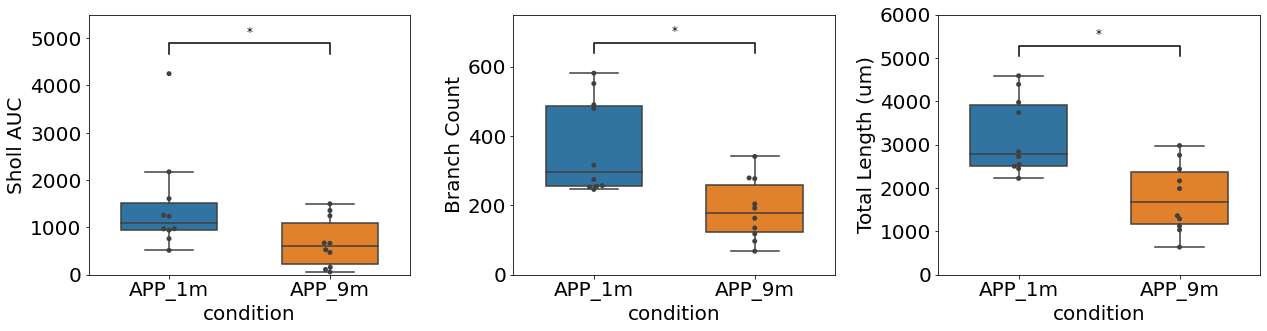

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# データ型を確認・変換
final_results_df['sholl_auc'] = final_results_df['sholl_auc'].astype(float)
final_results_df['branch_count'] = final_results_df['branch_count'].astype(float)
final_results_df['total_length_um'] = final_results_df['total_length_um'].astype(float)

filtered_results_df = final_results_df
print(f"Remaining data: {filtered_results_df.shape[0]} rows")

# 各指標ごとのデータ分割とMann-Whitney U検定
metrics = ['sholl_auc', 'branch_count', 'total_length_um']
titles = ["Sholl AUC", "Branch Count", "Total Length (um)"]

p_values = []  # 各検定のp値を格納
plt.figure(figsize=(18, 5))  # 横長のプロット

for i, metric in enumerate(metrics, 1):
    # データ分割
    app_1m = filtered_results_df[filtered_results_df['condition'] == 'APP_1m'][metric].dropna()
    app_9m = filtered_results_df[filtered_results_df['condition'] == 'APP_9m'][metric].dropna()

    # Mann-Whitney U検定
    if len(app_1m) > 1 and len(app_9m) > 1:
        u_stat, p_value = mannwhitneyu(app_1m, app_9m, alternative='two-sided')
        print(f"{metric}: U-statistic={u_stat}, P-value={p_value}")
    else:
        p_value = 1.0  # 検定が実行できない場合はp値を1に設定
        print(f"Not enough samples for Mann-Whitney U test for {metric}")

    # p値をリストに追加
    p_values.append(p_value)

# FDR補正（Benjamini-Hochberg法）
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')
print(f"Corrected P-values (FDR): {corrected_p_values}")
ylims = [5500, 750, 6000]
for i, (metric, corrected_p_value) in enumerate(zip(metrics, corrected_p_values), 1):
    # データ分割
    app_1m = filtered_results_df[filtered_results_df['condition'] == 'APP_1m'][metric].dropna()
    app_9m = filtered_results_df[filtered_results_df['condition'] == 'APP_9m'][metric].dropna()

    # 有意差のラベル設定
    significance = ""
    if corrected_p_value < 0.001:
        significance = "***"
    elif corrected_p_value < 0.01:
        significance = "**"
    elif corrected_p_value < 0.05:
        significance = "*"

    # ボックスプロットの作成
    plt.subplot(1, 3, i)  # 横に3つのプロット
    sns.boxplot(data=filtered_results_df, x='condition', y=metric, showfliers=False, width=0.6)
    sns.swarmplot(data=filtered_results_df, x='condition', y=metric, color=".25", size=5)

    # 有意差を表示
    if significance:
        x1, x2 = 0, 1
        y = filtered_results_df[metric].max() * 1.1  # 表示位置を上げる
        h = filtered_results_df[metric].max() * 0.05
        plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color='black')
        plt.text((x1 + x2) * .5, y + h * 1.5, significance, ha='center', va='bottom', fontsize=12)

    # y軸を0からスタート
    plt.ylim(0, ylims[i-1])

    # グラフの装飾


    plt.ylabel(titles[i-1], )

# プロットの表示
plt.tight_layout()
plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/Microglia Morphology analysis of APP1m vs 9m.pdf',
            transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()


In [24]:
import tifffile
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize_3d
from skan import csr
import datetime
import gc

# Sampleとatlas_idの設定
Samples = [
    "#4_APPmodel_APP1m_1_2022_1102_1304",
    "#4_APPmodel_APP1m_2_2022_1106_1708",
    "#4_APPmodel_APP1m_3_2022_1213_2151",
    "#4_APPmodel_APP1m_4_2023_0417_2052",
    "#5_APPmodel_APP9m_1_2023_0117_1352",
    "#5_APPmodel_APP9m_2_2023_0327_1425",
    "#5_APPmodel_APP9m_3_2023_0329_1611",
    "#5_APPmodel_APP9m_4_2023_0403_1443",
    "#4_APPmodel_Ctr1m_1_2022_1104_1550",
    "#4_APPmodel_Ctr1m_2_2022_1108_959",
    "#4_APPmodel_Ctr1m_3_2022_1209_1751",
    "#5_APPmodel_Ctr9m_1_2023_0130_1607",
    "#5_APPmodel_Ctr9m_2_2023_0216_2052",
    "#5_APPmodel_Ctr9m_3_2023_0322_2014",
    "#5_APPmodel_Ctr9m_4_2023_0518_1449"
]
Conditions = [
    "APP_1m", "APP_1m", "APP_1m", "APP_1m",
    "APP_9m", "APP_9m", "APP_9m", "APP_9m",
    "Ctr_1m", "Ctr_1m", "Ctr_1m",
    "Ctr_9m", "Ctr_9m", "Ctr_9m", "Ctr_9m"
]

# 各サンプルに対応するラベル (5つのラベルを指定)
label_intensities = {
    "#4_APPmodel_APP1m_1_2022_1102_1304": [44,54,136,76, 162],
    
    "#4_APPmodel_APP1m_2_2022_1106_1708",
    "#4_APPmodel_APP1m_3_2022_1213_2151",
    "#4_APPmodel_APP1m_4_2023_0417_2052",
    
    "#5_APPmodel_APP9m_1_2023_0117_1352": [40,41, 58, 74, 75,116],
    
    "#5_APPmodel_APP9m_2_2023_0327_1425",
    "#5_APPmodel_APP9m_3_2023_0329_1611",
    "#5_APPmodel_APP9m_4_2023_0403_1443",
    "#4_APPmodel_Ctr1m_1_2022_1104_1550",
    "#4_APPmodel_Ctr1m_2_2022_1108_959",
    "#4_APPmodel_Ctr1m_3_2022_1209_1751",
    "#5_APPmodel_Ctr9m_1_2023_0130_1607",
    "#5_APPmodel_Ctr9m_2_2023_0216_2052",
    "#5_APPmodel_Ctr9m_3_2023_0322_2014",
    "#5_APPmodel_Ctr9m_4_2023_0518_1449"    
    
}

results_list = []  # 複数サンプルの結果を格納
start_time = datetime.datetime.now()
print("Start time:", start_time)

for Sample, Condition in zip(Samples, Conditions):
    print(f"Processing: {Sample} ({Condition})")

    # atlas_idの取得
    atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

    # セグメント化画像のパス
    segmented_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
    )

    # データの読み込み
    segmented_image = tifffile.imread(segmented_path).astype(np.int32)
    print("Image loaded")

    # 指定ラベルのみを抽出
    labels_to_process = label_intensities.get(Sample, [])
    if not labels_to_process:
        print(f"No labels specified for {Sample}. Skipping.")
        continue

    filtered_image = np.isin(segmented_image, labels_to_process).astype(np.int32)
    print(f"Filtered image created with labels: {labels_to_process}")
    
    output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample + f'_valid_segmented_image_{atlas_id}.tif'
    tifffile.imsave(output_path, filtered_image.astype(np.float32))
    
    # スケルトン化
    skeleton = skeletonize_3d(filtered_image)
    print("Skeletonization completed")

    # スケルトンオブジェクトの作成
    skeleton_obj = csr.Skeleton(skeleton, spacing=(2.5, 0.65, 0.65))
    summary = csr.summarize(skeleton_obj)

    # スケルトン長を計算
    branch_lengths = summary.groupby('skeleton-id')['branch-distance'].sum()

    # 結果をDataFrameに格納
    results_df = pd.DataFrame({
        'label_id': branch_lengths.index,
        'total_length_um': branch_lengths.values
    })

    # サンプルとCondition情報を付与
    results_df['sample'] = Sample
    results_df['condition'] = Condition

    # リストに追加
    results_list.append(results_df)

    # メモリ解放
    del segmented_image, filtered_image, skeleton, skeleton_obj
    gc.collect()

    end_time = datetime.datetime.now()
    print(f"Duration: {end_time - start_time}")

# 全サンプルの結果を統合
final_results_df = pd.concat(results_list, ignore_index=True)

# 結果の表示
print(final_results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/all_samples_microglia_process_lengths.csv'
# final_results_df.to_csv(output_csv_path, index=False)
# print(f"Results saved to {output_csv_path}")

Start time: 2024-11-22 11:56:54.893292
Processing: #4_APPmodel_APP1m_1_2022_1102_1304 (APP_1m)
Image loaded
Filtered image created with labels: [44, 54, 136, 76, 162]
Skeletonization completed
Duration: 0:01:13.238621
Processing: #5_APPmodel_APP9m_1_2023_0117_1352 (APP_9m)
Image loaded
Filtered image created with labels: [40, 41, 58, 74, 75, 116]
Skeletonization completed
Duration: 0:02:30.014082
    label_id  total_length_um                              sample condition
0          1      3094.108538  #4_APPmodel_APP1m_1_2022_1102_1304    APP_1m
1          2      2586.050725  #4_APPmodel_APP1m_1_2022_1102_1304    APP_1m
2          3      1797.908013  #4_APPmodel_APP1m_1_2022_1102_1304    APP_1m
3          4      4176.377275  #4_APPmodel_APP1m_1_2022_1102_1304    APP_1m
4          5      2969.917926  #4_APPmodel_APP1m_1_2022_1102_1304    APP_1m
5          1      3031.997303  #5_APPmodel_APP9m_1_2023_0117_1352    APP_9m
6          2      1563.380965  #5_APPmodel_APP9m_1_2023_0117_1352   

In [ ]:
# Morphologyを抽出する

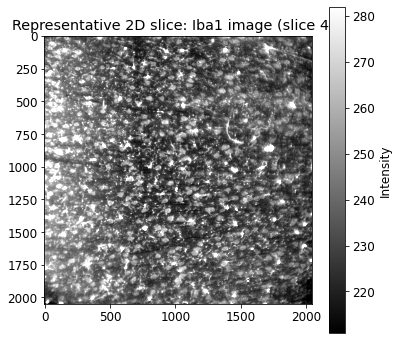

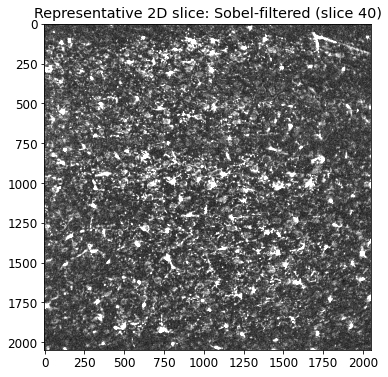

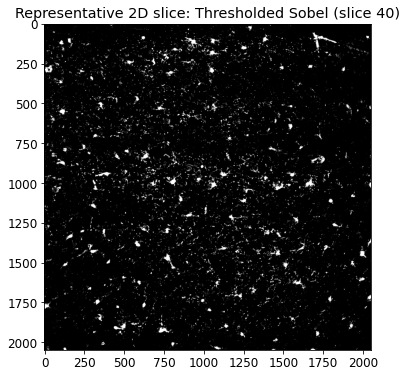

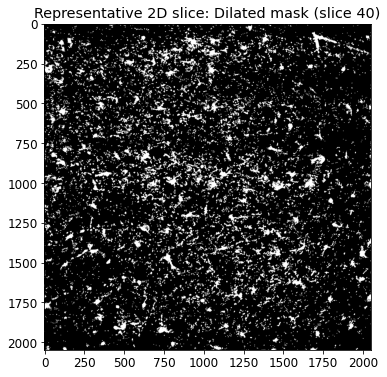

/home/mitani/my_env/lib64/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


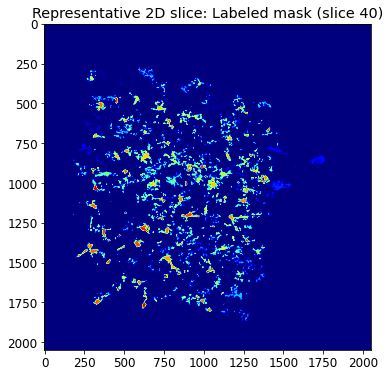

In [47]:
import numpy as np
import tifffile
from scipy import ndimage as ndi
from skimage.morphology import watershed, dilation, disk
from skimage.measure import label
import matplotlib.pyplot as plt
import pandas as pd

# Sampleとatlas_idの設定
Sample = "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304"
atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

# ファイルパスの設定
img_filename_Nuclear_Isocortex_to_ori = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") +
    f"_ROI_Iba1_{atlas_id}.tif"
)
csv_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") +
    f'_ROI_Iba1_points_{atlas_id}.csv'
)

center_x, center_y, center_z = 1024, 1024, 40
xy_roi_size = 1500  # 250 * 250
half_xy = xy_roi_size // 2
z_roi_size = 80

x_min, x_max = center_x - half_xy, center_x + half_xy
y_min, y_max = center_y - half_xy, center_y + half_xy

# 画像とCSVの読み込み
iba1_image = tifffile.imread(img_filename_Nuclear_Isocortex_to_ori)
iba1_points = pd.read_csv(csv_path)

# Z, X, Y 軸の範囲に収まるようにフィルタリング
iba1_points = iba1_points[
    (iba1_points['local_z'] >= 0) & (iba1_points['local_z'] < iba1_image.shape[0]) &  # Z軸
    (iba1_points['local_x'] >= 0) & (iba1_points['local_x'] < iba1_image.shape[2]) &  # X軸
    (iba1_points['local_y'] >= 0) & (iba1_points['local_y'] < iba1_image.shape[1])    # Y軸
]

# ROI範囲でさらに絞り込み
iba1_points = iba1_points[
    (iba1_points['local_x'] >= x_min) & (iba1_points['local_x'] < x_max) &
    (iba1_points['local_y'] >= y_min) & (iba1_points['local_y'] < y_max)
]

# CSVからピーク情報を取得 (local_x, local_y, local_zを整数に変換)
centers = iba1_points[['local_z', 'local_y', 'local_x']].values
centers = np.floor(centers).astype(int)  # 小数点以下を切り捨て

# 範囲外をクリップして安全にする
#centers[:, 0] = np.clip(centers[:, 0], 0, iba1_image.shape[0] - 1)  # Z軸
#centers[:, 1] = np.clip(centers[:, 1], 0, iba1_image.shape[1] - 1)  # Y軸
#centers[:, 2] = np.clip(centers[:, 2], 0, iba1_image.shape[2] - 1)  # X軸

# 画像スライスの可視化（intensityの範囲を設定）
percentile_5 = np.percentile(iba1_image[40], 5)
percentile_95 = np.percentile(iba1_image[40], 95)
plt.figure(figsize=(6, 6))
plt.imshow(iba1_image[40], cmap='gray', vmin=percentile_5, vmax=percentile_95)
plt.title("Representative 2D slice: Iba1 image (slice 40)")
plt.colorbar(label="Intensity")
plt.show()

# Sobelフィルタを適用 (X軸とY軸方向のみ)
sobel_x = ndi.sobel(iba1_image, axis=0)  # Sobelフィルタ (X軸方向)
sobel_y = ndi.sobel(iba1_image, axis=1)  # Sobelフィルタ (Y軸方向)
sobel_filtered_image = np.sqrt(sobel_x**2 + sobel_y**2)

percentile_5 = np.percentile(sobel_filtered_image[40], 5)
percentile_95 = np.percentile(sobel_filtered_image[40], 95)
plt.figure(figsize=(6, 6))
plt.imshow(sobel_filtered_image[40], cmap='gray', vmin=percentile_5, vmax=percentile_95)
plt.title("Representative 2D slice: Sobel-filtered (slice 40)")
plt.show()

output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_sobel_filtered_image_{atlas_id}.tif'
tifffile.imsave(output_path, sobel_filtered_image.astype(np.float32))

# 閾値処理 (画像の平均値 × 2.5)
threshold_value = np.mean(sobel_filtered_image) * 2.5
binary_mask = sobel_filtered_image > threshold_value
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask[40], cmap='gray')
plt.title("Representative 2D slice: Thresholded Sobel (slice 40)")
plt.show()

# マスクの膨張 (XY平面でのみdiskを使用)
dilated_mask = np.zeros_like(binary_mask)
for z in range(binary_mask.shape[0]):
    dilated_mask[z] = dilation(binary_mask[z], disk(2))  # diskでXY方向のみ膨張

plt.figure(figsize=(6, 6))
plt.imshow(dilated_mask[40], cmap='gray')
plt.title("Representative 2D slice: Dilated mask (slice 40)")
plt.show()

# マーカーを使用したウォーターシェッド分割
markers = np.zeros_like(iba1_image, dtype=np.int32)
for center in centers:
    markers[tuple(center)] = 1  # 3D空間で座標をマーク

markers = ndi.label(markers)[0]
segmented_image = watershed(-sobel_filtered_image, markers, mask=dilated_mask)

# セグメント化した画像を保存
output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
tifffile.imsave(output_path, segmented_image.astype(np.float32))

# ラベルマスクの2Dスライスを可視化
labeled_mask = label(segmented_image)
plt.figure(figsize=(6, 6))
plt.imshow(labeled_mask[40], cmap='jet')
plt.title("Representative 2D slice: Labeled mask (slice 40)")
plt.show()


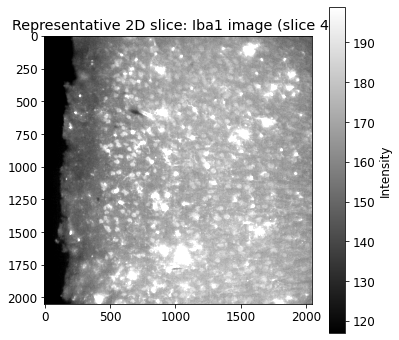

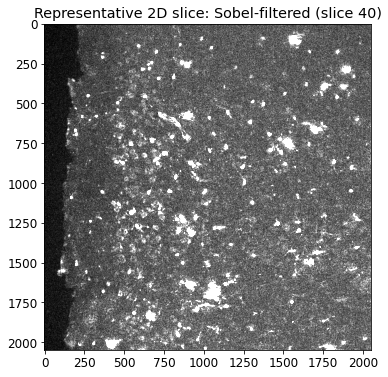

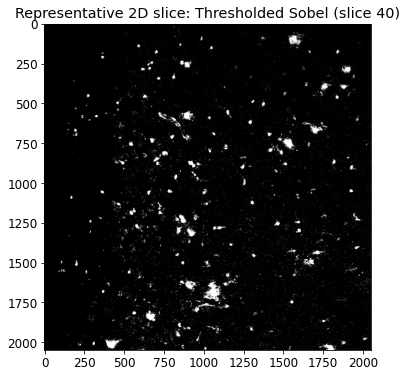

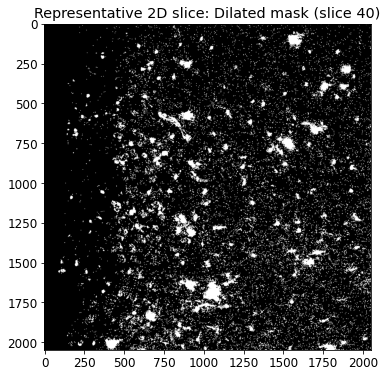

/home/mitani/my_env/lib64/python3.6/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


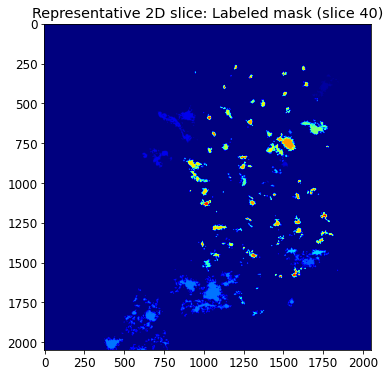

In [46]:
import numpy as np
import tifffile
from scipy import ndimage as ndi
from skimage.morphology import watershed, dilation, disk
from skimage.measure import label
import matplotlib.pyplot as plt
import pandas as pd

# Sampleとatlas_idの設定
Sample ="Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352"
atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

# ファイルパスの設定
img_filename_Nuclear_Isocortex_to_ori = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") +
    f"_ROI_Iba1_{atlas_id}.tif"
)
csv_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") +
    f'_ROI_Iba1_points_{atlas_id}.csv'
)

center_x, center_y, center_z = 1024, 1024, 40
xy_roi_size = 1500  # 250 * 250
half_xy = xy_roi_size // 2
z_roi_size = 80

x_min, x_max = center_x - half_xy, center_x + half_xy
y_min, y_max = center_y - half_xy, center_y + half_xy

# 画像とCSVの読み込み
iba1_image = tifffile.imread(img_filename_Nuclear_Isocortex_to_ori)
iba1_points = pd.read_csv(csv_path)

# Z, X, Y 軸の範囲に収まるようにフィルタリング
iba1_points = iba1_points[
    (iba1_points['local_z'] >= 0) & (iba1_points['local_z'] < iba1_image.shape[0]) &  # Z軸
    (iba1_points['local_x'] >= 0) & (iba1_points['local_x'] < iba1_image.shape[2]) &  # X軸
    (iba1_points['local_y'] >= 0) & (iba1_points['local_y'] < iba1_image.shape[1])    # Y軸
]

# ROI範囲でさらに絞り込み
iba1_points = iba1_points[
    (iba1_points['local_x'] >= x_min) & (iba1_points['local_x'] < x_max) &
    (iba1_points['local_y'] >= y_min) & (iba1_points['local_y'] < y_max)
]

# CSVからピーク情報を取得 (local_x, local_y, local_zを整数に変換)
centers = iba1_points[['local_z', 'local_y', 'local_x']].values
centers = np.floor(centers).astype(int)  # 小数点以下を切り捨て

# 範囲外をクリップして安全にする
#centers[:, 0] = np.clip(centers[:, 0], 0, iba1_image.shape[0] - 1)  # Z軸
#centers[:, 1] = np.clip(centers[:, 1], 0, iba1_image.shape[1] - 1)  # Y軸
#centers[:, 2] = np.clip(centers[:, 2], 0, iba1_image.shape[2] - 1)  # X軸

# 画像スライスの可視化（intensityの範囲を設定）
percentile_5 = np.percentile(iba1_image[40], 5)
percentile_95 = np.percentile(iba1_image[40], 95)
plt.figure(figsize=(6, 6))
plt.imshow(iba1_image[40], cmap='gray', vmin=percentile_5, vmax=percentile_95)
plt.title("Representative 2D slice: Iba1 image (slice 40)")
plt.colorbar(label="Intensity")
plt.show()

# Sobelフィルタを適用 (X軸とY軸方向のみ)
sobel_x = ndi.sobel(iba1_image, axis=0)  # Sobelフィルタ (X軸方向)
sobel_y = ndi.sobel(iba1_image, axis=1)  # Sobelフィルタ (Y軸方向)
sobel_filtered_image = np.sqrt(sobel_x**2 + sobel_y**2)

percentile_5 = np.percentile(sobel_filtered_image[40], 5)
percentile_95 = np.percentile(sobel_filtered_image[40], 95)
plt.figure(figsize=(6, 6))
plt.imshow(sobel_filtered_image[40], cmap='gray', vmin=percentile_5, vmax=percentile_95)
plt.title("Representative 2D slice: Sobel-filtered (slice 40)")
plt.show()

output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_sobel_filtered_image_{atlas_id}.tif'
tifffile.imsave(output_path, sobel_filtered_image.astype(np.float32))

# 閾値処理 (画像の平均値 × 2.5)
threshold_value = np.mean(sobel_filtered_image) * 2.5
binary_mask = sobel_filtered_image > threshold_value
plt.figure(figsize=(6, 6))
plt.imshow(binary_mask[40], cmap='gray')
plt.title("Representative 2D slice: Thresholded Sobel (slice 40)")
plt.show()

# マスクの膨張 (XY平面でのみdiskを使用)
dilated_mask = np.zeros_like(binary_mask)
for z in range(binary_mask.shape[0]):
    dilated_mask[z] = dilation(binary_mask[z], disk(2))  # diskでXY方向のみ膨張

plt.figure(figsize=(6, 6))
plt.imshow(dilated_mask[40], cmap='gray')
plt.title("Representative 2D slice: Dilated mask (slice 40)")
plt.show()

# マーカーを使用したウォーターシェッド分割
markers = np.zeros_like(iba1_image, dtype=np.int32)
for center in centers:
    markers[tuple(center)] = 1  # 3D空間で座標をマーク

markers = ndi.label(markers)[0]
segmented_image = watershed(-sobel_filtered_image, markers, mask=dilated_mask)

# セグメント化した画像を保存
output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
tifffile.imsave(output_path, segmented_image.astype(np.float32))

# ラベルマスクの2Dスライスを可視化
labeled_mask = label(segmented_image)
plt.figure(figsize=(6, 6))
plt.imshow(labeled_mask[40], cmap='jet')
plt.title("Representative 2D slice: Labeled mask (slice 40)")
plt.show()


In [26]:
import tifffile
import numpy as np
import pandas as pd

# Sampleとatlas_idの設定
Sample = "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304"
atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

# セグメント化画像とオリジナル画像のパス
segmented_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
)
original_img_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") + f"_ROI_Iba1_{atlas_id}.tif"
)

# データの読み込み
segmented_image = tifffile.imread(segmented_path).astype(np.int32)  # 整数型に変換
original_image = tifffile.imread(original_img_path)

# ボクセルサイズ (Z, Y, X) (μm)
voxel_size = (2.5, 0.65, 0.65)

# オリジナル画像の閾値 (mean * 1.5)
intensity_threshold = np.mean(original_image) * 1.5

# Somaマスクを作成
soma_mask = original_image > intensity_threshold

# 全ラベルの一覧を取得
unique_labels = np.unique(segmented_image)
unique_labels = unique_labels[unique_labels != 0]  # 背景(ラベル0)を除外

# Soma Volumeを効率的に計算
soma_volume_voxels = np.bincount(
    segmented_image[soma_mask].ravel(), minlength=unique_labels.max() + 1
)[unique_labels]

# μm^3単位で体積を計算
soma_volume_um3 = soma_volume_voxels * np.prod(voxel_size)

# 結果をDataFrameに格納
results_df = pd.DataFrame({
    'label_id': unique_labels,
    'soma_volume_um3': soma_volume_um3
})

# 結果の表示
print(results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_microglia_soma_features_{atlas_id}.csv'
# results_df.to_csv(output_csv_path, index=False)
# print(f"Results saved to {output_csv_path}")


     label_id  soma_volume_um3
0           1        113.01875
1           2       1373.12500
2           3          1.05625
3           4         85.55625
4           5        843.94375
..        ...              ...
378       385        794.30000
379       386        697.12500
380       387        560.86875
381       388        418.27500
382       389        461.58125

[383 rows x 2 columns]


In [ ]:
import tifffile
import numpy as np
import pandas as pd

# Sampleとatlas_idの設定
Sample = "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304"
atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

# セグメント化画像とオリジナル画像のパス
segmented_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
)
original_img_path = (
    '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
    Sample.replace("Neuronomics/", "") + f"_ROI_Iba1_{atlas_id}.tif"
)

# データの読み込み
segmented_image = tifffile.imread(segmented_path).astype(np.int32)  # 整数型に変換
original_image = tifffile.imread(original_img_path)

# ボクセルサイズ (Z, Y, X) (μm)
voxel_size = (2.5, 0.65, 0.65)

# オリジナル画像の閾値 (mean * 1.5)
intensity_threshold = np.mean(original_image) * 1.5

# Somaマスクを作成
soma_mask = original_image > intensity_threshold

# 全ラベルの一覧を取得
unique_labels = np.unique(segmented_image)
unique_labels = unique_labels[unique_labels != 0]  # 背景(ラベル0)を除外

# Soma Volumeを効率的に計算
soma_volume_voxels = np.bincount(
    segmented_image[soma_mask].ravel(), minlength=unique_labels.max() + 1
)[unique_labels]

# μm^3単位で体積を計算
soma_volume_um3 = soma_volume_voxels * np.prod(voxel_size)

# 結果をDataFrameに格納
results_df = pd.DataFrame({
    'label_id': unique_labels,
    'soma_volume_um3': soma_volume_um3
})

# 結果の表示
print(results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_microglia_soma_features_{atlas_id}.csv'
# results_df.to_csv(output_csv_path, index=False)
# print(f"Results saved to {output_csv_path}")


In [45]:
import tifffile
import numpy as np
import pandas as pd

# Sampleとatlas_idの設定
Samples = [
    "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304",
    "Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352"
]
results_list = []  # 複数サンプルの結果を格納

for Sample in Samples:
    # atlas_idの取得
    atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

    # セグメント化画像とオリジナル画像のパス
    segmented_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
    )
    original_img_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") + f"_ROI_Iba1_{atlas_id}.tif"
    )

    # データの読み込み
    segmented_image = tifffile.imread(segmented_path).astype(np.int32)  # 整数型に変換
    original_image = tifffile.imread(original_img_path)

    # ボクセルサイズ (Z, Y, X) (μm)
    voxel_size = (2.5, 0.65, 0.65)

    # オリジナル画像の閾値 (mean * 1.5)
    intensity_threshold = np.mean(original_image) * 1.5

    # Somaマスクを作成
    soma_mask = original_image > intensity_threshold
    output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_soma_image_{atlas_id}.tif'
    tifffile.imsave(output_path, soma_mask.astype(np.float32))
    
    # 全ラベルの一覧を取得
    unique_labels = np.unique(segmented_image)
    unique_labels = unique_labels[unique_labels != 0]  # 背景(ラベル0)を除外

    # Soma Volumeを効率的に計算
    soma_volume_voxels = np.bincount(
        segmented_image[soma_mask].ravel(), minlength=unique_labels.max() + 1
    )[unique_labels]

    # μm^3単位で体積を計算
    soma_volume_um3 = soma_volume_voxels * np.prod(voxel_size)

    # 結果をDataFrameに格納
    results_df = pd.DataFrame({
        'label_id': unique_labels,
        'soma_volume_um3': soma_volume_um3
    })

    # サンプル情報を付与
    results_df['sample'] = Sample

    # リストに追加
    results_list.append(results_df)

# 全サンプルの結果を統合
final_results_df = pd.concat(results_list, ignore_index=True)

# 結果の表示
print(final_results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/all_samples_microglia_soma_features.csv'
# final_results_df.to_csv(output_csv_path, index=Fa


     label_id  soma_volume_um3                                          sample
0           1        113.01875  Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
1           2       1373.12500  Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
2           3          1.05625  Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
3           4         85.55625  Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
4           5        843.94375  Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
..        ...              ...                                             ...
588       214       2153.69375  Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352
589       215        440.45625  Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352
590       216       1059.41875  Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352
591       217       1636.13125  Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352
592       218        669.66250  Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352

[593 rows x 3 columns]


In [49]:
import tifffile
import numpy as np
import pandas as pd
from skimage.morphology import skeletonize_3d
from scipy.ndimage import zoom

# Sampleとatlas_idの設定
Samples = [
    "Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304",
    "Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352"
]
results_list = []  # 複数サンプルの結果を格納

for Sample in Samples:
    print(Sample)
    # atlas_idの取得
    atlas_id = data_id[data_id["acronym"] == "FRP5"]["id"].values[0]

    # セグメント化画像のパス
    segmented_path = (
        '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' +
        Sample.replace("Neuronomics/", "") + f'_segmented_image_{atlas_id}.tif'
    )

    # データの読み込み
    segmented_image = tifffile.imread(segmented_path).astype(np.int32)  # 整数型に変換

    # ボクセルサイズ (Z, Y, X) (μm)
    voxel_size = (2.5, 0.65, 0.65)

    # Z 軸スケールを XY に合わせる (nearest neighbor 補間)
    z_scale_factor = voxel_size[0] / voxel_size[1]  # Zスケールに必要な倍率
    rescaled_image = zoom(segmented_image, (z_scale_factor, 1, 1), order=0)  # 補間 (order=0でnearest neighbor)
    print("rescaled")
    # 全体のスケルトン化を一括実行
    skeleton = skeletonize_3d(rescaled_image > 0)  # すべてのラベルを対象にスケルトン化
    print("skeltoned")
    # スケルトンの長さを計算
    total_lengths = np.bincount(rescaled_image[skeleton].ravel(), minlength=rescaled_image.max() + 1)
    print("legth")
    # ラベルと長さをフィルタリング（背景ラベルを除外）
    label_ids = np.arange(len(total_lengths))[1:]  # ラベル0を除外
    total_lengths_um = total_lengths[1:] * voxel_size[1]  # XYスケールに基づく長さに変換

    # 結果をDataFrameに格納
    results_df = pd.DataFrame({
        'label_id': label_ids,
        'total_length_um': total_lengths_um
    })

    # サンプル情報を付与
    results_df['sample'] = Sample

    # リストに追加
    results_list.append(results_df)

# 全サンプルの結果を統合
final_results_df = pd.concat(results_list, ignore_index=True)

# 結果の表示
print(final_results_df)

# 必要に応じてCSVに保存
# output_csv_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/all_samples_microglia_process_lengths.csv'
# final_results_df.to_csv(output_csv_path, index=False)
# print(f"Results saved to {


Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304
rescaled
skeltoned


MemoryError: Unable to allocate 19.2 PiB for an array with shape (308, 2048, 2048, 2048, 2048) and data type int32

In [51]:
skeleton.shape

(308, 2048, 2048)

In [52]:
output_path = '/export3/Imaging/ds4_Data5/mitani/Neurology/Extended Data Fig.5/' + Sample.replace("Neuronomics/", "") + f'_skeleton_image_{atlas_id}.tif'
tifffile.imsave(output_path, skeleton.astype(np.float32))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import pandas as pd

# データフレームを読み込む (仮にfinal_results_dfが存在していると仮定)

# データ分割
sample1 = final_results_df[final_results_df['sample'] == 'Neuronomics/#4_APPmodel_APP1m_1_2022_1102_1304']['total_length_um']
sample2 = final_results_df[final_results_df['sample'] == 'Neuronomics/#5_APPmodel_APP9m_1_2023_0117_1352']['total_length_um']

# t検定
t_stat, p_value = ttest_ind(sample1, sample2)

# 有意差のラベル設定
significance = ""
if p_value < 0.001:
    significance = "***"
elif p_value < 0.01:
    significance = "**"
elif p_value < 0.05:
    significance = "*"

# ボックスプロットの作成
plt.figure(figsize=(8, 6))
sns.boxplot(data=final_results_df, x='sample', y='soma_volume_um3')
#sns.swarmplot(data=final_results_df, x='sample', y='soma_volume_um3', color='black', alpha=0.6)

# プロット範囲を設定
#plt.ylim(0, 10000)

# 有意差を表示
x1, x2 = 0, 1
y, h = 9500, 200  # 有意差表示位置を調整
plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color='black')
plt.text((x1 + x2) * .5, y + h, significance, ha='center', va='bottom', fontsize=12)

# グラフの装飾
plt.title("Comparison of Soma Volume Across Samples", fontsize=14)
plt.xlabel("Sample", fontsize=12)
plt.ylabel("Soma Volume (um³)", fontsize=12)
plt.tight_layout()

# プロットの表示
plt.show()


In [36]:
sample1.mean()

1726.072454308094

In [37]:
sample2.mean()

5408.528125

In [38]:
sample1.median()

1480.8625000000002

In [39]:
sample2.median()

973.3343750000001

In [33]:
final_results_df

,label_id,soma_volume_um3,sample
0,1,113.01875,APPmodel
1,2,1373.12500,APPmodel
2,3,1.05625,APPmodel
3,4,85.55625,APPmodel
4,5,843.94375,APPmodel
...,...,...,...
588,214,2153.69375,APPmodel
589,215,440.45625,APPmodel
590,216,1059.41875,APPmodel
591,217,1636.13125,APPmodel


In [27]:
results_df

,label_id,soma_volume_um3
0,1,113.01875
1,2,1373.12500
2,3,1.05625
3,4,85.55625
4,5,843.94375
...,...,...
378,385,794.30000
379,386,697.12500
380,387,560.86875
381,388,418.27500


In [490]:
conditions = {

    "WT_1m": ["#4_APPmodel_Ctr1m_1_2022_1104_1550",],

    "WT_9m": [  "#5_APPmodel_Ctr9m_2_2023_0216_2052" ,],

    "APP_1m": [ "#4_APPmodel_APP1m_2_2022_1106_1708",],

    "APP_9m": ["#5_APPmodel_APP9m_3_2023_0329_1611" ],
      
}

In [491]:
grid_mode=0
Samples = ["Neuronomics/" + path for paths in conditions.values() for path in paths]
Samples

['Neuronomics/#4_APPmodel_Ctr1m_1_2022_1104_1550',
 'Neuronomics/#5_APPmodel_Ctr9m_2_2023_0216_2052',
 'Neuronomics/#4_APPmodel_APP1m_2_2022_1106_1708',
 'Neuronomics/#5_APPmodel_APP9m_3_2023_0329_1611']

###########  New Sample ####################
Start time: 2024-10-01 20:02:01.514165
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_Ctr1m_1_2022_1104_1550/param_multichannel-rank.json
48768
98553097
2797


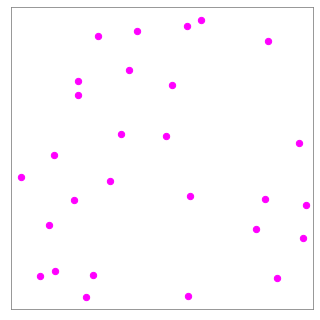

###########  New Sample ####################
Start time: 2024-10-01 20:02:07.841295
/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_Ctr9m_2_2023_0216_2052/param_multichannel-rank.json
49968
108267909
1955


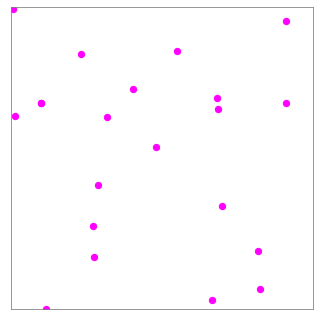

###########  New Sample ####################
Start time: 2024-10-01 20:02:38.756431
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_2_2022_1106_1708/param_multichannel-rank.json
50279
103470326
2756


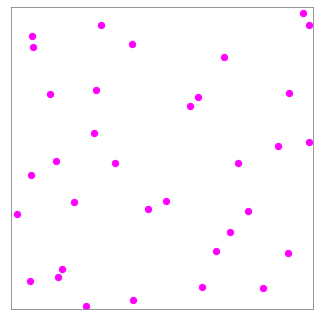

###########  New Sample ####################
Start time: 2024-10-01 20:02:51.448594
/home/mitani/CUBIC-informatics/param/Neuronomics/#5_APPmodel_APP9m_3_2023_0329_1611/param_multichannel-rank.json
58235
113487659
2044


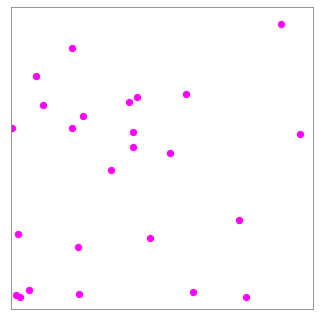

In [500]:
import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json
import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json
from scipy.spatial import cKDTree
import numpy as np
import datetime
from scipy.ndimage import gaussian_filter

dt_local = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('structureness', 'f4'), ('blobness', 'f4'), ('intensity', 'f4'),
    ('size', 'u2'), ('padding', 'u2'), ('intensity2', 'f4'), ('intensity3', 'f4')
])


dt_annotated = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('is_positive2','f4'),('is_positive3','f4')
])



dt_annotated_init = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'),('intensity','f4'),('structureness','f4'), # ここのis_positiveはinitial classifyによるもの
    ('intensity_2','f4'), ('intensity_3','f4')
])

dt_annotated_classified_intensity = np.dtype([
    ('local_x', 'f4'), ('local_y', 'f4'), ('local_z', 'f4'),
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('atlas_id', 'u2'), ('is_positive','f4'), ('intensity','f4'),('structureness','f4'),
    ('intensity2','f4'),('intensity3','f4'), # ここのis_positiveはinitial classifyによるものにする
    ('norm_intensity_2','f4'), ('norm_intensity_3','f4')
])

# 必要なdtypeの定義
dt_needed = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('intensity','f4'),('structureness','f4')
])

dt_classified = np.dtype([
    ('is_positive','bool'), ('is_positive2','bool'),('is_positive3','bool')
])

dt_classified2 = np.dtype([
   ('is_positive','bool'), ('intensity','f4'),('intensity_2','f4'), ('intensity_3','f4')
])

    
dt_annotation2 = np.dtype([
  ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
  ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
  ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
  ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])
NeuN_cluster_threshold_list = [0.80] # だいたいが0.75のはず
NeuN_cluster_noise_threshold_list = [0.55] # だいたいが0.75のはず
Iba1_cluster_threshold_list = [0.55] # だいたいが0.45のはず

ROI_xy_pix = 200 # 偶数で
ROI_z_pix = 40 # 偶数で

atlas_id = 18697  # SSp-un2/3

#closest_sample = closest_sample1
#Samples = ["Neuronomics/" + info['sample_name'] for info in closest_sample['closest_samples'].values()]

for Sample in Samples:
#Sample = Samples[0]
    #try:
    print("###########  New Sample ####################")
    start_time = datetime.datetime.now()
    print("Start time:", start_time)
    param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
    print(param_path)

    with open(param_path) as f:
        param = json.load(f)

    fw_dir_nu = param["dst_basedir"]
    grids = np.fromfile(fw_dir_nu + "/SCA_registered_cell_coordinates_ver2_2_Grid.bin", dtype=dt_annotation2 )# stitchedは10um scaleになっている
    src = np.fromfile(fw_dir_nu + "/SCA_registered_cell_coordinates_ver2_2.bin", dtype=dt_annotation2 )
    src_extracted = src[src["atlas_id"]==atlas_id]
    print(len(src_extracted))


    fw_dir_nu = param["dst_basedir"]
    Classified_cells = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
             "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
             "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin", dtype = dt_simple2 )
    print(len(Classified_cells))
    src_extracted_Iba1 = src[(src["atlas_id"]==atlas_id)*(Classified_cells["Iba1_positive"]>0)]
    print(len(src_extracted_Iba1))


    import numpy as np
    import matplotlib.pyplot as plt

    # 中心座標 (um)
    center_x, center_y, center_z = 105 * 25, 221 * 25, 66 * 25

    # ROIの範囲 (um)
    roi_x_min, roi_x_max = center_x - 100, center_x + 100
    roi_y_min, roi_y_max = center_y - 100, center_y + 100
    roi_z_min, roi_z_max = center_z - 50, center_z + 50

    # src_extracted から SCA_x, SCA_y を抽出
    SCA_x = src_extracted_Iba1['SCA_x']
    SCA_y = src_extracted_Iba1['SCA_y']
    SCA_z = src_extracted_Iba1['SCA_z']

    # ROI内に含まれる点をフィルタリング
    mask = (
        (SCA_x >= roi_x_min) & (SCA_x <= roi_x_max) &
        (SCA_y >= roi_y_min) & (SCA_y <= roi_y_max) &
        (SCA_z >= roi_z_min) & (SCA_z <= roi_z_max)
    )

    filtered_x = SCA_x[mask]
    filtered_y = SCA_y[mask]

    # 2Dプロットの作成
    plt.figure(figsize=(6, 6))
    plt.scatter(filtered_x, filtered_y, c='magenta', s=40)

    # 軸の削除（ラベルと目盛り）
    plt.xticks([])  # X軸の目盛りを消す
    plt.yticks([])  # Y軸の目盛りを消す
    plt.gca().spines['top'].set_visible(True)
    plt.gca().spines['right'].set_visible(True)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    # 枠線の色をグレーに設定
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
        spine.set_color('gray')  # 枠線の色をグレーに設定
    
    # X軸とY軸の範囲を固定（200 um）
    plt.xlim([roi_x_min, roi_x_max])
    plt.ylim([roi_y_min, roi_y_max])
    # 等方的にするための設定
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

    # 余白を最小限にして画像を保存
    plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.6/Microglia_ROI_plot_' +  str(Sample.replace("Neuronomics/", "")) +'.pdf',
                transparent=True, dpi=300, bbox_inches='tight', pad_inches=0)

    plt.show()

    # グラフの表示
    plt.show()



In [76]:
import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json
from scipy.spatial import cKDTree
import datetime
from scipy.ndimage import gaussian_filter

# Define all necessary dtype structures
dt_annotation2 = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
    ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

# Thresholds
NeuN_cluster_threshold_list = [0.80] 
NeuN_cluster_noise_threshold_list = [0.55] 
Iba1_cluster_threshold_list = [0.55] 

atlas_id = 18697

for Sample in Samples:
    print("###########  New Sample ####################")
    start_time = datetime.datetime.now()
    print("Start time:", start_time)
    param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
    print(param_path)

    with open(param_path) as f:
        param = json.load(f)

    fw_dir_nu = param["dst_basedir"]
    # Load source data
    src = np.fromfile(fw_dir_nu + "/SCA_registered_cell_coordinates_ver2_2.bin", dtype=dt_annotation2)
    print(len(src))

    # Load classified cells
    Classified_cells = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
             "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
             "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin", dtype = dt_simple2 )
    print(len(Classified_cells))

    print("###########  Neighbor calculate ####################")
    # Select microglia positive cells
    src_microglia = src[Classified_cells["Iba1_positive"] > 0].copy()
    src_microglia_extracted = src_microglia[src_microglia["atlas_id"] == atlas_id]

    # Extract SCA_xyz coordinates for src_microglia_extracted
    sca_coords_extracted = np.column_stack((src_microglia_extracted['SCA_x'], src_microglia_extracted['SCA_y'], src_microglia_extracted['SCA_z']))

    # Create the KDTree
    tree = cKDTree(sca_coords_extracted)

    # Calculate nearest neighbor distances (k=2 to exclude self)
    distances, _ = tree.query(sca_coords_extracted, k=2)
    # Use the second neighbor (index 1) to exclude self-distance
    nearest_neighbor_distances = distances[:, 1]
    nearest_neighbor_distance_mean = np.mean(nearest_neighbor_distances)
    nearest_neighbor_distance_median = np.median(nearest_neighbor_distances)
    nearest_neighbor_distance_5_percentile = np.percentile(nearest_neighbor_distances, 5)

    # Calculate averaged neighbor distance for k=11 to exclude self
    distances_10, _ = tree.query(sca_coords_extracted, k=11)
    # Use distances from the second nearest neighbor onward (ignoring self at index 0)
    averaged_neighbor_distances = np.mean(distances_10[:, 1:], axis=1)
    averaged_neighbor_distance_mean = np.mean(averaged_neighbor_distances)
    averaged_neighbor_distance_median = np.median(averaged_neighbor_distances)
    averaged_neighbor_distance_5_percentile = np.percentile(averaged_neighbor_distances, 5)

    # Save the results as CSV
    result_df = pd.DataFrame({
        'atlas_id': [atlas_id],
        'nearest_neighbor_distance_mean': [nearest_neighbor_distance_mean],
        'nearest_neighbor_distance_median': [nearest_neighbor_distance_median],
        'nearest_neighbor_distance_5_percentile': [nearest_neighbor_distance_5_percentile],
        'averaged_neighbor_distance_mean': [averaged_neighbor_distance_mean],
        'averaged_neighbor_distance_median': [averaged_neighbor_distance_median],
        'averaged_neighbor_distance_5_percentile': [averaged_neighbor_distance_5_percentile]
    })
    
    print(result_df)
    
    result_path = fw_dir_nu + "/" + str(atlas_id) + "_Microglial_Neighbor_distance.csv"
    result_df.to_csv(result_path, index=False)
    print(f"Results saved to {result_path}")

    end_time = datetime.datetime.now()
    print("End time:", end_time)
    print("Duration:", end_time - start_time)


###########  New Sample ####################
Start time: 2024-09-30 14:31:07.753644
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_Ctr1m_1_2022_1104_1550/param_multichannel-rank.json
98553097
98553097
###########  Neighbor calculate ####################
   atlas_id  nearest_neighbor_distance_mean  nearest_neighbor_distance_median  \
0     18697                       34.561996                          36.70216   

   nearest_neighbor_distance_5_percentile  averaged_neighbor_distance_mean  \
0                                 8.08997                        57.193745   

   averaged_neighbor_distance_median  averaged_neighbor_distance_5_percentile  
0                          56.265952                                45.789995  
Results saved to /export3/Imaging/Axial/Neurorology/#4_APPmodel_Ctr1m_1_2022_1104_1550/intensities_//18697_Microglial_Neighbor_distance.csv
End time: 2024-09-30 14:31:13.744633
Duration: 0:00:05.990989
###########  New Sample ####################
Start

102573617
102573617
###########  Neighbor calculate ####################
   atlas_id  nearest_neighbor_distance_mean  nearest_neighbor_distance_median  \
0     18697                       34.355404                         36.425102   

   nearest_neighbor_distance_5_percentile  averaged_neighbor_distance_mean  \
0                                9.323255                        57.392979   

   averaged_neighbor_distance_median  averaged_neighbor_distance_5_percentile  
0                          56.187728                                46.218512  
Results saved to /export2/Imaging/ds4_Data3/temp_from_ds1_Imaging3/#4_APPmodel_APP1m_3_2022_1213_2151/intensities_//18697_Microglial_Neighbor_distance.csv
End time: 2024-09-30 14:35:05.288650
Duration: 0:00:29.526018
###########  New Sample ####################
Start time: 2024-09-30 14:35:05.288781
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_4_2023_0417_2052/param_multichannel-rank.json
108454462
108454462
###########  

In [160]:
conditions = {

    "WT_1m": ["#4_APPmodel_Ctr1m_1_2022_1104_1550","#4_APPmodel_Ctr1m_2_2022_1108_959","#4_APPmodel_Ctr1m_3_2022_1209_1751"],

    "WT_9m": [ "#5_APPmodel_Ctr9m_1_2023_0130_1607", "#5_APPmodel_Ctr9m_2_2023_0216_2052" ,"#5_APPmodel_Ctr9m_3_2023_0322_2014","#5_APPmodel_Ctr9m_4_2023_0518_1449"],

    "APP_1m": ["#4_APPmodel_APP1m_1_2022_1102_1304", "#4_APPmodel_APP1m_2_2022_1106_1708","#4_APPmodel_APP1m_3_2022_1213_2151","#4_APPmodel_APP1m_4_2023_0417_2052", ],

    "APP_9m": ["#5_APPmodel_APP9m_1_2023_0117_1352","#5_APPmodel_APP9m_2_2023_0327_1425", "#5_APPmodel_APP9m_3_2023_0329_1611", "#5_APPmodel_APP9m_4_2023_0403_1443" ],
      
}

In [287]:
import numpy as np
import tifffile
import os
import pickle
import joblib
import pandas as pd
from matplotlib import pyplot as plt
import concurrent.futures
import gc
import json
from scipy.spatial import cKDTree
import datetime
from scipy.ndimage import gaussian_filter

# Define all necessary dtype structures
dt_annotation2 = np.dtype([
    ('stitched_x', 'f4'), ('stitched_y', 'f4'), ('stitched_z', 'f4'),
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'),
    ('SCA_x', 'f4'), ('SCA_y', 'f4'), ('SCA_z', 'f4'),
    ('atlas_id', 'u2')
])
dt_simple2 = np.dtype([
    ('mapped_x', 'f4'), ('mapped_y', 'f4'), ('mapped_z', 'f4'), 
    ('NeuN_positive','f4'),('Iba1_positive','f4'),('atlas_id', 'u2')
])

# Thresholds
NeuN_cluster_threshold_list = [0.80] 
NeuN_cluster_noise_threshold_list = [0.55] 
Iba1_cluster_threshold_list = [0.55] 

#atlas_id = 18697 # SSp-un2/3
#atlas_id = 657 # SSp-m2/3
#atlas_id = 973 # VISl2/3
#atlas_id = 296 # ACAv2/3
#atlas_id = 542 # RSPv1
 #atlas_id =  806 # SSs2/3
 #atlas_id =  981# SSp-bfd1
 #atlas_id = 943 # MOP2/3
 #atlas_id =  18705 # SSp-un5
atlas_id = 844 # MOp6a

#atlas_id = 48516 # ccb
#atlas_id = 621 # V
#atlas_id = 863 # rust
#atlas_id = 436 # fx
#atlas_id = 445 # SPVO

for Sample in Samples:
    print("###########  New Sample ####################")
    start_time = datetime.datetime.now()
    print("Start time:", start_time)
    param_path = f"/home/mitani/CUBIC-informatics/param/{Sample}/param_multichannel-rank.json"
    print(param_path)

    with open(param_path) as f:
        param = json.load(f)

    fw_dir_nu = param["dst_basedir"]
    # Load source data
    src = np.fromfile(fw_dir_nu + "/SCA_registered_cell_coordinates_ver2_2.bin", dtype=dt_annotation2)
    print(len(src))

    # Load classified cells
    Classified_cells = np.fromfile(fw_dir_nu + "/For_PDF_clustering_base_data_classified_NeuN_" + str(NeuN_cluster_threshold_list[0]) +
             "_noise_"+str(NeuN_cluster_noise_threshold_list[0]) +
             "_Iba1_" +str(Iba1_cluster_threshold_list[0])  +"_2.bin", dtype = dt_simple2 )
    print(len(Classified_cells))

    print("###########  Neighbor calculate ####################")
    # Select microglia positive cells
    src_microglia = src[Classified_cells["Iba1_positive"] > 0].copy()
    src_microglia_extracted = src_microglia[src_microglia["atlas_id"] == atlas_id]
    print(len(src_microglia_extracted))
    # Extract SCA_xyz coordinates for src_microglia_extracted
    sca_coords_extracted = np.column_stack((src_microglia_extracted['SCA_x'], src_microglia_extracted['SCA_y'], src_microglia_extracted['SCA_z']))

    # Create the KDTree
    tree = cKDTree(sca_coords_extracted)

    # Calculate nearest neighbor distances (k=2 to exclude self)
    distances, _ = tree.query(sca_coords_extracted, k=2)
    # Use the second neighbor (index 1) to exclude self-distance
    nearest_neighbor_distances = distances[:, 1]
    nearest_neighbor_distance_mean = np.mean(nearest_neighbor_distances)
    nearest_neighbor_distance_median = np.median(nearest_neighbor_distances)
    
    # Get the 5-percentile values from nearest_neighbor_distances
    nearest_neighbor_5_percentile_value = np.percentile(nearest_neighbor_distances, 5)
    nearest_neighbor_5_percentile_distances = nearest_neighbor_distances[nearest_neighbor_distances <= nearest_neighbor_5_percentile_value]

    # Calculate the mean and median of the 5-percentile distances
    nearest_neighbor_5_percentile_mean = np.mean(nearest_neighbor_5_percentile_distances)
    nearest_neighbor_5_percentile_median = np.median(nearest_neighbor_5_percentile_distances)

    # Calculate averaged neighbor distance for k=11 to exclude self
    distances_10, _ = tree.query(sca_coords_extracted, k=11)
    # Use distances from the second nearest neighbor onward (ignoring self at index 0)
    averaged_neighbor_distances = np.mean(distances_10[:, 1:], axis=1)
    averaged_neighbor_distance_mean = np.mean(averaged_neighbor_distances)
    averaged_neighbor_distance_median = np.median(averaged_neighbor_distances)

    # Save the results as CSV
    result_df = pd.DataFrame({
        'atlas_id': [atlas_id],
        'nearest_neighbor_distance_mean': [nearest_neighbor_distance_mean],
        'nearest_neighbor_distance_median': [nearest_neighbor_distance_median],
        'nearest_neighbor_5_percentile_mean': [nearest_neighbor_5_percentile_mean],
        'nearest_neighbor_5_percentile_median': [nearest_neighbor_5_percentile_median],
        'averaged_neighbor_distance_mean': [averaged_neighbor_distance_mean],
        'averaged_neighbor_distance_median': [averaged_neighbor_distance_median]
    })
    
    print(result_df)
    
    result_path = fw_dir_nu + "/" + str(atlas_id) + "_Microglial_Neighbor_distance.csv"
    result_df.to_csv(result_path, index=False)
    print(f"Results saved to {result_path}")

    end_time = datetime.datetime.now()
    print("End time:", end_time)
    print("Duration:", end_time - start_time)


###########  New Sample ####################
Start time: 2024-09-30 22:56:40.042780
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_Ctr1m_1_2022_1104_1550/param_multichannel-rank.json
98553097
98553097
###########  Neighbor calculate ####################
27086
   atlas_id  nearest_neighbor_distance_mean  nearest_neighbor_distance_median  \
0       844                        31.99049                          35.44632   

   nearest_neighbor_5_percentile_mean  nearest_neighbor_5_percentile_median  \
0                             5.54275                              5.730705   

   averaged_neighbor_distance_mean  averaged_neighbor_distance_median  
0                        52.869597                          52.596007  
Results saved to /export3/Imaging/Axial/Neurorology/#4_APPmodel_Ctr1m_1_2022_1104_1550/intensities_//844_Microglial_Neighbor_distance.csv
End time: 2024-09-30 22:56:45.486455
Duration: 0:00:05.443675
###########  New Sample ####################
Start time: 202

102573617
102573617
###########  Neighbor calculate ####################
27883
   atlas_id  nearest_neighbor_distance_mean  nearest_neighbor_distance_median  \
0       844                       31.361716                         34.381479   

   nearest_neighbor_5_percentile_mean  nearest_neighbor_5_percentile_median  \
0                            5.389932                              5.680064   

   averaged_neighbor_distance_mean  averaged_neighbor_distance_median  
0                        52.091902                          51.975282  
Results saved to /export2/Imaging/ds4_Data3/temp_from_ds1_Imaging3/#4_APPmodel_APP1m_3_2022_1213_2151/intensities_//844_Microglial_Neighbor_distance.csv
End time: 2024-09-30 23:00:31.500403
Duration: 0:00:27.843975
###########  New Sample ####################
Start time: 2024-09-30 23:00:31.500506
/home/mitani/CUBIC-informatics/param/Neuronomics/#4_APPmodel_APP1m_4_2023_0417_2052/param_multichannel-rank.json
108454462
108454462
###########  Neighbor c

Analyzing metric: nearest_neighbor_distance_mean


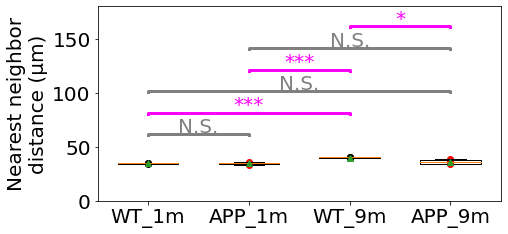

In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests  # For FDR correction
import json

atlas_id = 18697 # SSp-un2/3
#atlas_id = 657 # SSp-m2/3
#atlas_id = 973 # VISl2/3
#atlas_id = 296 # ACAv2/3
#atlas_id = 542 # RSPv1
#atlas_id =  806 # SSs2/3
#atlas_id =  981# SSp-bfd1
#atlas_id = 943 # MOp2/3
#atlas_id =  18705 # SSp-un5
#atlas_id = 844 # MOp6a

#atlas_id = 48516 # ccb
#atlas_id = 621 # V
#atlas_id = 445 # 

# Function to load all the CSV files for a given condition
def load_condition_data(condition_paths, column_name):
    data = []
    for Sample in condition_paths:
        param_path = f"/home/mitani/CUBIC-informatics/param/Neuronomics/{Sample}/param_multichannel-rank.json"
        try:
            with open(param_path) as f:
                param = json.load(f)
        except FileNotFoundError:
            print(f"File not found: {param_path}")
            continue

        fw_dir_nu = param["dst_basedir"]
    
        csv_path = fw_dir_nu + f"{atlas_id}_Microglial_Neighbor_distance.csv"
        try:
            df = pd.read_csv(csv_path)
            data.append(df[column_name])  # Load data based on the column name
        except FileNotFoundError:
            print(f"CSV not found: {csv_path}")
        except KeyError:
            print(f"CSV does not have '{column_name}' column: {csv_path}")
    
    if len(data) == 0:
        print("No data loaded for this condition")
        return np.array([])  # Return empty array if no data is loaded
    
    concatenated_data = np.concatenate(data)
    return concatenated_data

# Define the 6 metrics (mean, median, and 5-percentile for nearest and averaged neighbor distances)
metrics = [
    "nearest_neighbor_distance_mean",
   # "nearest_neighbor_distance_median",
   # 'nearest_neighbor_5_percentile_mean',
   # 'nearest_neighbor_5_percentile_median',
   # "averaged_neighbor_distance_mean",
   # "averaged_neighbor_distance_median",
]

# Function to add significance markers with custom style (colored lines and adjusted p-values)
def add_significance_marker(x1, x2, y, p_val, height_shift, significance_level=0.05):
    y_adjusted = y + height_shift  # Adjust height for each comparison
    color = 'magenta' if p_val < significance_level else 'gray'
    
    # Add the connecting line between two points
    plt.plot([x1, x1, x2, x2], [y_adjusted - 1, y_adjusted, y_adjusted, y_adjusted - 1], lw=3, color=color)
    
    # Place p-value or N.S. text above the line
    if p_val < significance_level:
        plt.text((x1 + x2) * 0.5, y_adjusted + 2, "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*", ha='center', color=color)
    else:
        plt.text((x1 + x2) * 0.5, y_adjusted + 2, 'N.S.', ha='center', color=color)

# Loop over each metric
for metric in metrics:
    print(f"Analyzing metric: {metric}")
    
    # Load the data for all conditions
    data_WT_1m = load_condition_data(conditions['WT_1m'], metric)
    data_WT_9m = load_condition_data(conditions['WT_9m'], metric)
    data_APP_1m = load_condition_data(conditions['APP_1m'], metric)
    data_APP_9m = load_condition_data(conditions['APP_9m'], metric)

    # Reorder conditions: WT_1m, WT_9m, APP_1m, APP_9m
    conditions_labels = ['WT_1m', 'APP_1m','WT_9m',  'APP_9m']
    data = [data_WT_1m, data_APP_1m, data_WT_9m,  data_APP_9m]

    # Perform pairwise t-tests and store the results
    p_values = []
    comparisons = [
        (0, 1),  # WT_1m vs WT_9m
        (0, 2),  # WT_1m vs APP_1m
        (0, 3),  # WT_1m vs APP_9m
        (1, 2),  # WT_9m vs APP_1m
        (1, 3),  # WT_9m vs APP_9m
        (2, 3),  # APP_1m vs APP_9m
    ]

    for (i, j) in comparisons:
        if len(data[i]) > 0 and len(data[j]) > 0:
            _, p_val = stats.ttest_ind(data[i], data[j])
            p_values.append(p_val)
        else:
            p_values.append(1)  # If no data, assume no significance

    # Apply FDR correction
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Create the plot
    plt.figure(figsize=(8, 3))

    # Scatter plot for each condition
    positions = [1, 2, 3, 4]  # X-axis positions for the conditions
    for i, cond_data in enumerate(data):
        if len(cond_data) > 0:
            plt.scatter([positions[i]] * len(cond_data), cond_data, color='black' if i % 2 == 0 else 'red')

    # Boxplot overlay
    plt.boxplot([d for d in data if len(d) > 0], positions=[positions[i] for i, d in enumerate(data) if len(d) > 0], widths=0.6, showmeans=True)

    # Set the labels
    plt.xticks(positions, conditions_labels)
    #plt.ylabel(f"{metric} (µm)")
    plt.ylabel("Nearest neighbor\ndistance (µm)")
    ymax_lim = 180
    plt.ylim(0, ymax_lim)

    # Add FDR-corrected significance markers with color adjustments (gray for N.S., magenta for significant)
    y_max = max([max(d) for d in data if len(d) > 0]) + 1
    height_shift = ymax_lim / 9  # Initial height adjustment for significance lines
    for (i, (x1, x2)) in enumerate(comparisons):
        add_significance_marker(x1 + 1, x2 + 1, y_max, pvals_corrected[i], height_shift)
        height_shift +=  ymax_lim / 9 # Increase height for each comparison

    # レイアウト調整
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

    # PDFとして図を保存
    plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.6/Neighbor_distance_SSp-un23.pdf',
                transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


Analyzing metric: nearest_neighbor_distance_mean


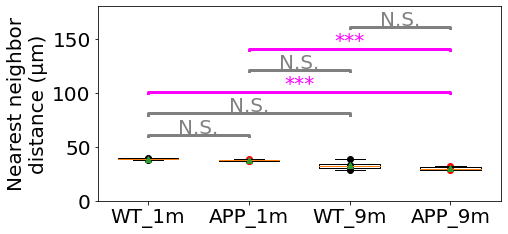

In [370]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests  # For FDR correction
import json

#atlas_id = 18697 # SSp-un2/3
#atlas_id = 657 # SSp-m2/3
#atlas_id = 973 # VISl2/3
#atlas_id = 296 # ACAv2/3
#atlas_id = 542 # RSPv1
#atlas_id =  806 # SSs2/3
#atlas_id =  981# SSp-bfd1
#atlas_id = 943 # MOp2/3
#atlas_id =  18705 # SSp-un5
#atlas_id = 844 # MOp6a

#atlas_id = 48516 # ccb
#atlas_id = 621 # V
atlas_id = 445 # SPVO

# Function to load all the CSV files for a given condition
def load_condition_data(condition_paths, column_name):
    data = []
    for Sample in condition_paths:
        param_path = f"/home/mitani/CUBIC-informatics/param/Neuronomics/{Sample}/param_multichannel-rank.json"
        try:
            with open(param_path) as f:
                param = json.load(f)
        except FileNotFoundError:
            print(f"File not found: {param_path}")
            continue

        fw_dir_nu = param["dst_basedir"]
    
        csv_path = fw_dir_nu + f"{atlas_id}_Microglial_Neighbor_distance.csv"
        try:
            df = pd.read_csv(csv_path)
            data.append(df[column_name])  # Load data based on the column name
        except FileNotFoundError:
            print(f"CSV not found: {csv_path}")
        except KeyError:
            print(f"CSV does not have '{column_name}' column: {csv_path}")
    
    if len(data) == 0:
        print("No data loaded for this condition")
        return np.array([])  # Return empty array if no data is loaded
    
    concatenated_data = np.concatenate(data)
    return concatenated_data

# Define the 6 metrics (mean, median, and 5-percentile for nearest and averaged neighbor distances)
metrics = [
    "nearest_neighbor_distance_mean",
   # "nearest_neighbor_distance_median",
   # 'nearest_neighbor_5_percentile_mean',
   # 'nearest_neighbor_5_percentile_median',
   # "averaged_neighbor_distance_mean",
   # "averaged_neighbor_distance_median",
]

# Function to add significance markers with custom style (colored lines and adjusted p-values)
def add_significance_marker(x1, x2, y, p_val, height_shift, significance_level=0.05):
    y_adjusted = y + height_shift  # Adjust height for each comparison
    color = 'magenta' if p_val < significance_level else 'gray'
    
    # Add the connecting line between two points
    plt.plot([x1, x1, x2, x2], [y_adjusted - 1, y_adjusted, y_adjusted, y_adjusted - 1], lw=3, color=color)
    
    # Place p-value or N.S. text above the line
    if p_val < significance_level:
        plt.text((x1 + x2) * 0.5, y_adjusted + 2, "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*", ha='center', color=color)
    else:
        plt.text((x1 + x2) * 0.5, y_adjusted + 2, 'N.S.', ha='center', color=color)

# Loop over each metric
for metric in metrics:
    print(f"Analyzing metric: {metric}")
    
    # Load the data for all conditions
    data_WT_1m = load_condition_data(conditions['WT_1m'], metric)
    data_WT_9m = load_condition_data(conditions['WT_9m'], metric)
    data_APP_1m = load_condition_data(conditions['APP_1m'], metric)
    data_APP_9m = load_condition_data(conditions['APP_9m'], metric)

    # Reorder conditions: WT_1m, WT_9m, APP_1m, APP_9m
    conditions_labels = ['WT_1m', 'APP_1m','WT_9m',  'APP_9m']
    data = [data_WT_1m, data_APP_1m, data_WT_9m,  data_APP_9m]

    # Perform pairwise t-tests and store the results
    p_values = []
    comparisons = [
        (0, 1),  # WT_1m vs WT_9m
        (0, 2),  # WT_1m vs APP_1m
        (0, 3),  # WT_1m vs APP_9m
        (1, 2),  # WT_9m vs APP_1m
        (1, 3),  # WT_9m vs APP_9m
        (2, 3),  # APP_1m vs APP_9m
    ]

    for (i, j) in comparisons:
        if len(data[i]) > 0 and len(data[j]) > 0:
            _, p_val = stats.ttest_ind(data[i], data[j])
            p_values.append(p_val)
        else:
            p_values.append(1)  # If no data, assume no significance

    # Apply FDR correction
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Create the plot
    plt.figure(figsize=(8, 3))

    # Scatter plot for each condition
    positions = [1, 2, 3, 4]  # X-axis positions for the conditions
    for i, cond_data in enumerate(data):
        if len(cond_data) > 0:
            plt.scatter([positions[i]] * len(cond_data), cond_data, color='black' if i % 2 == 0 else 'red')

    # Boxplot overlay
    plt.boxplot([d for d in data if len(d) > 0], positions=[positions[i] for i, d in enumerate(data) if len(d) > 0], widths=0.6, showmeans=True)

    # Set the labels
    plt.xticks(positions, conditions_labels)
    plt.ylabel("Nearest neighbor\ndistance (µm)")
    ymax_lim = 180
    plt.ylim(0, ymax_lim)

    # Add FDR-corrected significance markers with color adjustments (gray for N.S., magenta for significant)
    y_max = max([max(d) for d in data if len(d) > 0]) + 1
    height_shift = ymax_lim / 9  # Initial height adjustment for significance lines
    for (i, (x1, x2)) in enumerate(comparisons):
        add_significance_marker(x1 + 1, x2 + 1, y_max, pvals_corrected[i], height_shift)
        height_shift +=  ymax_lim / 9 # Increase height for each comparison

    # レイアウト調整
    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

    # PDFとして図を保存
    plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.6/Neighbor_distance_SPVO.pdf',
                transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


Analyzing metric: Iba1+ density (/mm3)


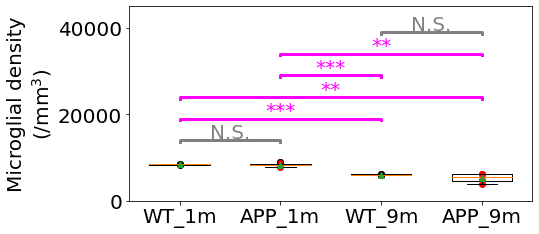

In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests  # For FDR correction
import json

atlas_id = 18697  # 特定のatlas_id (例: SSp-un2/3)

# Function to load all the CSV files for a given condition
def load_condition_data(condition_paths, atlas_id, column_name):
    data = []
    for Sample in condition_paths:
        param_path = f"/home/mitani/CUBIC-informatics/param/Neuronomics/{Sample}/param_multichannel-rank.json"
        try:
            with open(param_path) as f:
                param = json.load(f)
        except FileNotFoundError:
            print(f"File not found: {param_path}")
            continue

        fw_dir_nu = param["dst_basedir"]
    
        csv_path = fw_dir_nu + "/Regional_cellome4.csv"  # Iba1+ density を含むファイル
        try:
            df = pd.read_csv(csv_path)
            # 指定された atlas_id に基づいてフィルタリング
            df_filtered = df[df["atlasID"] == atlas_id]
            if column_name in df_filtered.columns:
                data.append(df_filtered[column_name].values)  # カラム名に基づいてデータを抽出
            else:
                print(f"Column '{column_name}' not found in {csv_path}")
        except FileNotFoundError:
            print(f"CSV not found: {csv_path}")
        except KeyError:
            print(f"Error accessing column '{column_name}' in {csv_path}")
    
    if len(data) == 0:
        print("No data loaded for this condition")
        return np.array([])  # データがロードされない場合、空の配列を返す
    
    concatenated_data = np.concatenate(data)
    return concatenated_data

# Iba1+ density カラムを指定
column_name = "Iba1+ density (/mm3)"



# Metrics to analyze (column names)
metrics = ["Iba1+ density (/mm3)"]  # 解析したいメトリクスをリストにする

# 修正した関数：比較間の有意差を示す線とマーカーを追加
# Modified function to make the significance markers clear and well-positioned
def add_significance_marker(x1, x2, y, p_val, height_shift, significance_level=0.05):
    y_adjusted = y + height_shift  # 比較ごとに高さを調整
    color = 'magenta' if p_val < significance_level else 'gray'
    
    # 2つの比較対象の間に垂直および水平な線を追加
    #plt.plot([x1, x1], [y_adjusted - 200, y_adjusted], lw=3, color=color)  # 左側の垂直線を表示
    #plt.plot([x2, x2], [y_adjusted - 200, y_adjusted], lw=3, color=color)  # 右側の垂直線を表示
    #plt.plot([x1, x2], [y_adjusted, y_adjusted], lw=3, color=color)      # 上側の水平線を表示
    plt.plot([x1, x1, x2, x2], [y_adjusted - 400, y_adjusted, y_adjusted, y_adjusted - 400], lw=3, color=color)
    
    # p値またはN.S.を上部に表示
    mid_x = (x1 + x2) * 0.5  # 中央のx座標を計算
    if p_val < significance_level:
        plt.text(mid_x, y_adjusted + 500, "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*", ha='center',  color=color)
    else:
        plt.text(mid_x, y_adjusted + 500, 'N.S.', ha='center', color=color)




# Loop to plot the data and significance markers
for metric in metrics:
    print(f"Analyzing metric: {metric}")
    
    # Load data for all conditions
    data_WT_1m = load_condition_data(conditions['WT_1m'], atlas_id, metric)
    data_WT_9m = load_condition_data(conditions['WT_9m'], atlas_id, metric)
    data_APP_1m = load_condition_data(conditions['APP_1m'], atlas_id, metric)
    data_APP_9m = load_condition_data(conditions['APP_9m'], atlas_id, metric)

    # Reorder the conditions
    conditions_labels = ['WT_1m', 'APP_1m','WT_9m',  'APP_9m']
    data = [data_WT_1m,  data_APP_1m,data_WT_9m, data_APP_9m]

    # Run t-tests for each pair of conditions
    p_values = []
    comparisons = [
        (0, 1),  # WT_1m vs WT_9m
        (0, 2),  # WT_1m vs APP_1m
        (0, 3),  # WT_1m vs APP_9m
        (1, 2),  # WT_9m vs APP_1m
        (1, 3),  # WT_9m vs APP_9m
        (2, 3),  # APP_1m vs APP_9m
    ]

    for (i, j) in comparisons:
        if len(data[i]) > 0 and len(data[j]) > 0:
            _, p_val = stats.ttest_ind(data[i], data[j])
            p_values.append(p_val)
        else:
            p_values.append(1)  # N.S. for missing data

    # Apply FDR correction to the p-values
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Create the plot
    plt.figure(figsize=(8, 3))

    # Scatter plot for each condition's data
    positions = [1, 2, 3, 4]  # Positions on the x-axis
    for i, cond_data in enumerate(data):
        if len(cond_data) > 0:
            plt.scatter([positions[i]] * len(cond_data), cond_data, color='black' if i % 2 == 0 else 'red')

    # Overlay boxplots
    plt.boxplot([d for d in data if len(d) > 0], positions=[positions[i] for i, d in enumerate(data) if len(d) > 0], widths=0.6, showmeans=True)

    # Set axis labels
    plt.xticks(positions, conditions_labels)
    plt.ylabel("Microglial density\n(/mm$^3$)")
    ymax_lim = 45000
    plt.ylim(0, ymax_lim)
    
    # Add significance markers based on FDR correction results
    # Add FDR-corrected significance markers with color adjustments (gray for N.S., magenta for significant)
    y_max = max([max(d) for d in data if len(d) > 0]) + 1
    height_shift = ymax_lim / 9  # Initial height adjustment for significance lines
    for (i, (x1, x2)) in enumerate(comparisons):
        add_significance_marker(x1 + 1, x2 + 1, y_max, pvals_corrected[i], height_shift)
        height_shift +=  ymax_lim / 9 # Increase height for each comparison

    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

    # PDFとして図を保存
    plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.6/Microglia_Density_SSp-un23.pdf',
                transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()




Analyzing metric: Iba1+ density (/mm3)


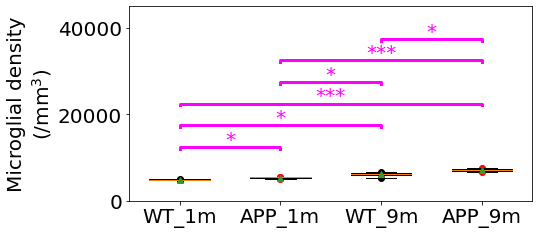

In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import multipletests  # For FDR correction
import json

#atlas_id = 18697  # 特定のatlas_id (例: SSp-un2/3)
atlas_id = 445 # SPVO
# Function to load all the CSV files for a given condition
def load_condition_data(condition_paths, atlas_id, column_name):
    data = []
    for Sample in condition_paths:
        param_path = f"/home/mitani/CUBIC-informatics/param/Neuronomics/{Sample}/param_multichannel-rank.json"
        try:
            with open(param_path) as f:
                param = json.load(f)
        except FileNotFoundError:
            print(f"File not found: {param_path}")
            continue

        fw_dir_nu = param["dst_basedir"]
    
        csv_path = fw_dir_nu + "/Regional_cellome4.csv"  # Iba1+ density を含むファイル
        try:
            df = pd.read_csv(csv_path)
            # 指定された atlas_id に基づいてフィルタリング
            df_filtered = df[df["atlasID"] == atlas_id]
            if column_name in df_filtered.columns:
                data.append(df_filtered[column_name].values)  # カラム名に基づいてデータを抽出
            else:
                print(f"Column '{column_name}' not found in {csv_path}")
        except FileNotFoundError:
            print(f"CSV not found: {csv_path}")
        except KeyError:
            print(f"Error accessing column '{column_name}' in {csv_path}")
    
    if len(data) == 0:
        print("No data loaded for this condition")
        return np.array([])  # データがロードされない場合、空の配列を返す
    
    concatenated_data = np.concatenate(data)
    return concatenated_data

# Iba1+ density カラムを指定
column_name = "Iba1+ density (/mm3)"



# Metrics to analyze (column names)
metrics = ["Iba1+ density (/mm3)"]  # 解析したいメトリクスをリストにする

# 修正した関数：比較間の有意差を示す線とマーカーを追加
# Modified function to make the significance markers clear and well-positioned
def add_significance_marker(x1, x2, y, p_val, height_shift, significance_level=0.05):
    y_adjusted = y + height_shift  # 比較ごとに高さを調整
    color = 'magenta' if p_val < significance_level else 'gray'
    
    # 2つの比較対象の間に垂直および水平な線を追加
    #plt.plot([x1, x1], [y_adjusted - 200, y_adjusted], lw=3, color=color)  # 左側の垂直線を表示
    #plt.plot([x2, x2], [y_adjusted - 200, y_adjusted], lw=3, color=color)  # 右側の垂直線を表示
    #plt.plot([x1, x2], [y_adjusted, y_adjusted], lw=3, color=color)      # 上側の水平線を表示
    plt.plot([x1, x1, x2, x2], [y_adjusted - 400, y_adjusted, y_adjusted, y_adjusted - 400], lw=3, color=color)
    
    # p値またはN.S.を上部に表示
    mid_x = (x1 + x2) * 0.5  # 中央のx座標を計算
    if p_val < significance_level:
        plt.text(mid_x, y_adjusted + 500, "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*", ha='center',  color=color)
    else:
        plt.text(mid_x, y_adjusted + 500, 'N.S.', ha='center', color=color)




# Loop to plot the data and significance markers
for metric in metrics:
    print(f"Analyzing metric: {metric}")
    
    # Load data for all conditions
    data_WT_1m = load_condition_data(conditions['WT_1m'], atlas_id, metric)
    data_WT_9m = load_condition_data(conditions['WT_9m'], atlas_id, metric)
    data_APP_1m = load_condition_data(conditions['APP_1m'], atlas_id, metric)
    data_APP_9m = load_condition_data(conditions['APP_9m'], atlas_id, metric)

    # Reorder the conditions
    conditions_labels = ['WT_1m', 'APP_1m','WT_9m',  'APP_9m']
    data = [data_WT_1m,  data_APP_1m,data_WT_9m, data_APP_9m]

    # Run t-tests for each pair of conditions
    p_values = []
    comparisons = [
        (0, 1),  # WT_1m vs WT_9m
        (0, 2),  # WT_1m vs APP_1m
        (0, 3),  # WT_1m vs APP_9m
        (1, 2),  # WT_9m vs APP_1m
        (1, 3),  # WT_9m vs APP_9m
        (2, 3),  # APP_1m vs APP_9m
    ]

    for (i, j) in comparisons:
        if len(data[i]) > 0 and len(data[j]) > 0:
            _, p_val = stats.ttest_ind(data[i], data[j])
            p_values.append(p_val)
        else:
            p_values.append(1)  # N.S. for missing data

    # Apply FDR correction to the p-values
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # Create the plot
    plt.figure(figsize=(8, 3))

    # Scatter plot for each condition's data
    positions = [1, 2, 3, 4]  # Positions on the x-axis
    for i, cond_data in enumerate(data):
        if len(cond_data) > 0:
            plt.scatter([positions[i]] * len(cond_data), cond_data, color='black' if i % 2 == 0 else 'red')

    # Overlay boxplots
    plt.boxplot([d for d in data if len(d) > 0], positions=[positions[i] for i, d in enumerate(data) if len(d) > 0], widths=0.6, showmeans=True)

    # Set axis labels
    plt.xticks(positions, conditions_labels)
    plt.ylabel("Microglial density\n(/mm$^3$)")
    ymax_lim = 45000
    plt.ylim(0, ymax_lim)
    
    # Add significance markers based on FDR correction results
    # Add FDR-corrected significance markers with color adjustments (gray for N.S., magenta for significant)
    y_max = max([max(d) for d in data if len(d) > 0]) + 1
    height_shift = ymax_lim / 9  # Initial height adjustment for significance lines
    for (i, (x1, x2)) in enumerate(comparisons):
        add_significance_marker(x1 + 1, x2 + 1, y_max, pvals_corrected[i], height_shift)
        height_shift +=  ymax_lim / 9 # Increase height for each comparison

    plt.tight_layout()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)

    # PDFとして図を保存
    plt.savefig('/export3/Imaging/ds4_Data5/mitani/Neurology/Fig.6/Microglia_Density_SPVO.pdf',
                transparent=True, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()


